### EXPLORATION 

In [1]:
WAVELET_TYPE = 'db4' #db4 is smoother than db1
LEVEL = 4 #3, 4 

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import pywt
from imageio import imread
from scipy import sparse
from tqdm import tqdm
from PIL import Image


WAVELET_TYPE = WAVELET_TYPE #db4 is smoother than db1
LEVEL = LEVEL #3, 4        
KEEP_RATIO = 0.2
IMG_SIZE = (256, 256) 
# IMP: resizing image to 256x256 for both MRI (630 x 630) and CT (512 x 512)
# def get_sparse_wavelet_vector(img_path):
#     # Grayscale ('L') conversion
#     # This handles both the 1-channel PNGs (CT) and 3-channel JPGs (MRI)
#     # automatically, converting them to a standard 2D (H, W) array.
#     img = Image.open(img_path).convert('L').resize(IMG_SIZE)
#     img_arr = np.array(img)
#     coeffs = pywt.wavedec2(img_arr, wavelet=WAVELET_TYPE, level=LEVEL)
#     coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    
#     flat_coeffs = coeff_arr.reshape(-1)
#     threshold_idx = int(np.floor((1 - KEEP_RATIO) * len(flat_coeffs)))
    
#     sorted_abs = np.sort(np.abs(flat_coeffs))
#     threshold = sorted_abs[threshold_idx]
#     flat_coeffs[np.abs(flat_coeffs) <= threshold] = 0

#     return sparse.csr_matrix(flat_coeffs)


import numpy as np
import pywt
from scipy import sparse
from PIL import Image

def _normalize_img(img_arr: np.ndarray, norm: str = "robust") -> np.ndarray:
    x = img_arr.astype(np.float32)
    stats = {}
    
    if norm == "none":
        return x, stats 

    if norm == "zscore":
        mu = x.mean()
        sd = x.std() + 1e-8
        stats = {'mu': mu, 'std': sd}
        return (x - mu) / sd, stats 

    if norm == "robust":
        med = np.median(x)
        q1, q3 = np.percentile(x, [25, 75])
        iqr = (q3 - q1) + 1e-8
        stats = {'median': med, 'iqr': iqr}
        return (x - med) / iqr, stats 

    if norm == "clip01":
        lo, hi = np.percentile(x, [1, 99])
        x = np.clip(x, lo, hi)
        stats = {'min': lo, 'max': hi}
        x = (x - lo) / (hi - lo + 1e-8)
        return x, stats 

def get_sparse_wavelet_vector(
    img_path,
    norm: str = "robust",
    band: str = "all",            
    keep_ratio: float = KEEP_RATIO,
    wavelet: str = WAVELET_TYPE,
    level: int = LEVEL,
    img_size=IMG_SIZE,
    threshold_mode: str = "per_image"  # keep for future extensions
):
    img = Image.open(img_path).convert("L").resize(img_size)
    img_arr = np.array(img)

    img_arr, stats = _normalize_img(img_arr, norm=norm)
    coeffs = pywt.wavedec2(img_arr, wavelet=wavelet, level=level)

    if band == "approx_only":
        cA = coeffs[0]
        zeros_details = [tuple(np.zeros_like(b) for b in detail) for detail in coeffs[1:]]
        coeffs = [cA] + zeros_details
    elif band == "detail_only":
        cA = np.zeros_like(coeffs[0])
        coeffs = [cA] + coeffs[1:]
    elif band != "all":
        raise ValueError(f"Unknown band='{band}'")

    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1).astype(np.float32)

    if keep_ratio < 1.0:
        k = int(np.floor((1 - keep_ratio) * flat.size))
        # guard for extreme keep_ratio
        k = np.clip(k, 0, flat.size - 1)

        thresh = np.partition(np.abs(flat), k)[k]
        flat[np.abs(flat) <= thresh] = 0.0

    return sparse.csr_matrix(flat), coeff_slices, stats 

import os 
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
DATA_DIR = os.path.join(HOME_DIR, 'data/ct2mri/images')
files_A = glob.glob(f'{DATA_DIR}/trainA/*.png')
files_B = glob.glob(f'{DATA_DIR}/trainB/*.jpg')

dataset_list = []
for f in files_A:
    dataset_list.append({'path': f, 'domain': 'A', 'label': 0})
for f in files_B:
    dataset_list.append({'path': f, 'domain': 'B', 'label': 1})

random.shuffle(dataset_list)
print(f"Processing {len(dataset_list)} images...")

data_rows = []
meta_rows = []

for item in tqdm(dataset_list):
    vec, _, stats = get_sparse_wavelet_vector(item['path'], norm='zscore')
    data_rows.append(vec)
    item.update(stats)
    meta_rows.append(item)

W = sparse.vstack(data_rows)
df_meta = pd.DataFrame(meta_rows)

print(f"Matrix W constructed. Shape: {W.shape}")
print(f"Sparsity: {1.0 - (W.nnz / (W.shape[0] * W.shape[1])):.4f}")

In [16]:
from scipy import sparse
import os 
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
EXP_DIR = os.path.join(HOME_DIR, 'experiments/ct2mri')
sparse.save_npz(f'{EXP_DIR}/data_matrix_W.npz', W)
# which row corresponds to which image/domain
df_meta.to_csv(f'{EXP_DIR}/metadata_W.csv', index=False)


In [3]:
from scipy import sparse
import pandas as pd
import os 
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
EXP_DIR = os.path.join(HOME_DIR, 'experiments/ct2mri')
W = sparse.load_npz(f'{EXP_DIR}/data_matrix_W.npz')
df_meta = pd.read_csv(f'{EXP_DIR}/metadata_W.csv')

print(f"Loaded W: {W.shape}")
print(f"Loaded Meta: {len(df_meta)} rows")

Loaded W: (3486, 79524)
Loaded Meta: 3486 rows


In [4]:
def reconstruct_image_with_denorm(sparse_row, slices, dest_shape, wavelet_shape, mu, std, wavelet=WAVELET_TYPE):
    """
    Reconstructs image from sparse vector and denormalizes it using stored mu/std.
    """
    dense_vec = sparse_row.toarray().flatten()
    coeffs_reshaped = dense_vec.reshape(wavelet_shape)
    coeffs_rebuilt = pywt.array_to_coeffs(coeffs_reshaped, slices, output_format='wavedec2')
    recon_norm = pywt.waverec2(coeffs_rebuilt, wavelet=wavelet)

    recon = (recon_norm * std) + mu
    recon = recon[:dest_shape[0], :dest_shape[1]]
    return np.clip(recon, 0, 255).astype('uint8')

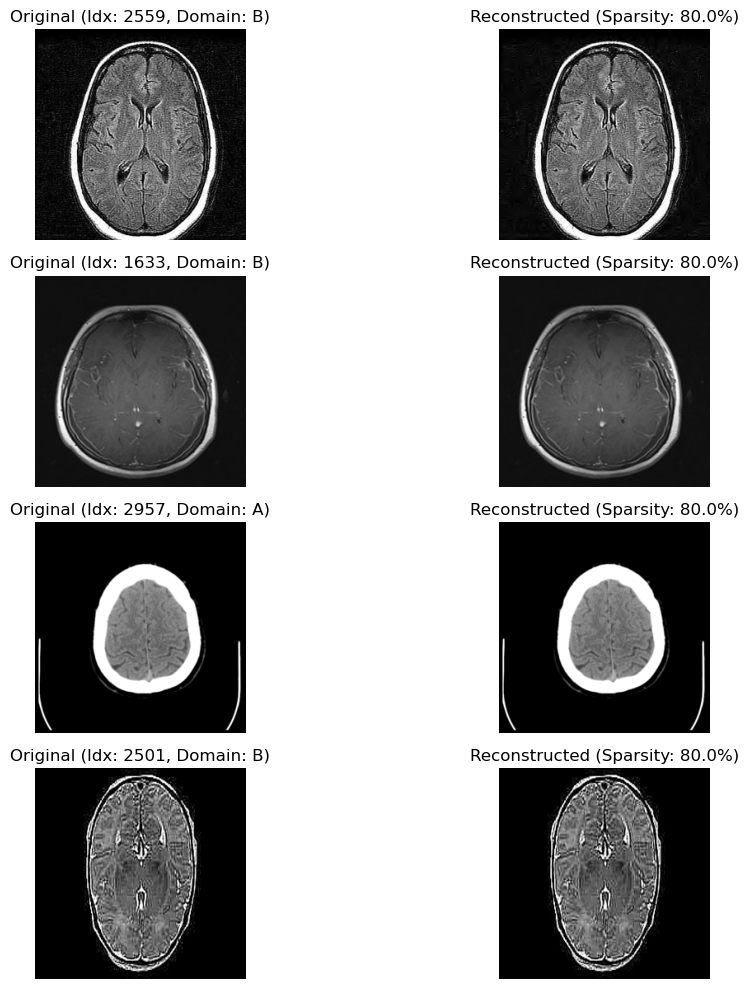

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
from PIL import Image

IMG_SIZE = (256, 256)
WAVELET_TYPE = WAVELET_TYPE
LEVEL = LEVEL #3, 4

# Compute Shapes using Dummy Image (Same as before) ---
# Note: np.zeros(IMG_SIZE) creates a 2D array (H, W), which is perfect for grayscale.
dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape  

def reconstruct_image_from_vector(sparse_row, slices, dest_shape, wavelet_shape):
    """
    Reconstructs a Grayscale image from a sparse flattened wavelet vector.
    """
    dense_vec = sparse_row.toarray().flatten()
    coeffs_reshaped = dense_vec.reshape(wavelet_shape)
    coeffs_rebuilt = pywt.array_to_coeffs(coeffs_reshaped, slices, output_format='wavedec2')
    recon = pywt.waverec2(coeffs_rebuilt, wavelet=WAVELET_TYPE)
    recon = recon[:dest_shape[0], :dest_shape[1]]
    return np.clip(recon, 0, 255).astype('uint8')

indices_to_check = np.random.choice(len(df_meta), 4, replace=False)

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices_to_check):
    row_data = df_meta.iloc[idx]
    mu_val = row_data['mu']
    std_val = row_data['std']
    original_path = row_data['path']
    domain = row_data['domain']
    img_orig = Image.open(original_path).convert('L').resize(IMG_SIZE)

    sparse_vector = W[idx]
    img_recon = reconstruct_image_with_denorm(sparse_vector, coeff_slices, IMG_SIZE, coeff_shape,
                                              mu_val, std_val)
    #img_recon = reconstruct_image_from_vector(sparse_vector, coeff_slices, IMG_SIZE, coeff_shape)
    # img_recon = (img_recon * std_val) + mu_val
    plt.subplot(4, 2, 2*i + 1)
    plt.imshow(img_orig, cmap='gray') 
    plt.title(f"Original (Idx: {idx}, Domain: {domain})")
    plt.axis('off')
    
    # Plotting Reconstructed
    plt.subplot(4, 2, 2*i + 2)
    plt.imshow(img_recon, cmap='gray') 
    
    sparsity = 1.0 - (sparse_vector.nnz / sparse_vector.shape[1])
    plt.title(f"Reconstructed (Sparsity: {sparsity:.1%})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

N_COMPONENTS = 256  # Number of singular values/vectors to compute
RANDOM_STATE = 42

print(f"Starting SVD with {N_COMPONENTS} components...")
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
# Z is new latent representation: shape (N_samples, N_components)
Z = svd.fit_transform(W)

print(f"SVD Complete.")
print(f"Latent shape Z: {Z.shape}")

Starting SVD with 256 components...


SVD Complete.
Latent shape Z: (3486, 256)


In [23]:
import numpy as np
import joblib 

np.save(f'{EXP_DIR}/Z_latent.npy', Z)
joblib.dump(svd, f'{EXP_DIR}/svd_model.joblib')

print("Saved Z and SVD model successfully.")

Saved Z and SVD model successfully.


In [6]:
import joblib 
import numpy as np
Z = np.load(f'{EXP_DIR}/Z_latent.npy')
svd = joblib.load(f'{EXP_DIR}/svd_model.joblib')

/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Total Variance Explained: 83.70%


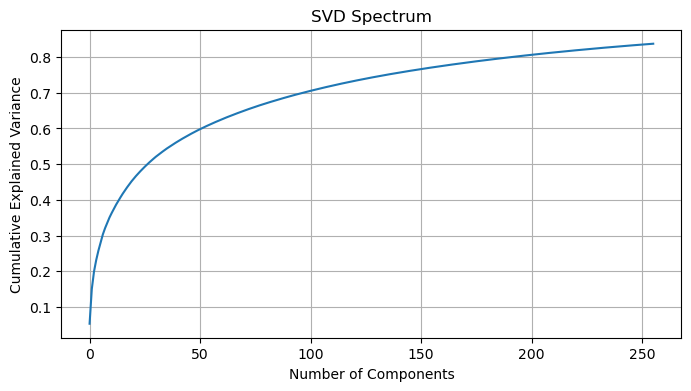

In [7]:
explained_var = svd.explained_variance_ratio_.sum()
print(f"Total Variance Explained: {explained_var:.2%}")

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Spectrum')
plt.grid(True)
plt.show()


C          | Train Acc  | Val Acc    | Active Feats (domain-varying) | Inactive (domain-invariant)
--------------------------------------------------------------------------------
0.01       | 0.833      | 0.804      | 22                   | 234
0.1        | 0.964      | 0.937      | 158                  | 98


/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead

1.0        | 0.990      | 0.954      | 221                  | 35


/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


10.0       | 1.000      | 0.944      | 230                  | 26

Selection Complete.
Content Dimensions (Invariant): 236
Style Dimensions (Domain Specific): 20


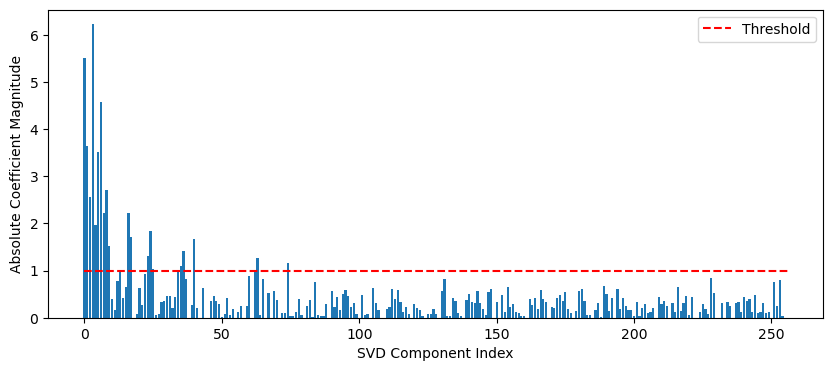

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

y = np.array([item['label'] for item in df_meta.to_dict('records')])
X_train, X_val, y_train, y_val = train_test_split(Z, y, test_size=0.2, random_state=42)

# C = inverse of regularization strength 
# Small C = Fewer active features (more sparsity)
# trying a few values to find the balance
c_values = [0.01, 0.1, 1.0, 10.0]

best_model = None
best_acc = 0

print(f"{'C':<10} | {'Train Acc':<10} | {'Val Acc':<10} | {'Active Feats (domain-varying)':<20} | {'Inactive (domain-invariant)'}")
print("-" * 80)

for C in c_values:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", C=C, solver='liblinear', max_iter=5000)
    )
    model.fit(X_train, y_train)
    # clf = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
    # using l1 penalty to ensure sparsity
    # clf.fit(X_train, y_train)
    
    # train_acc = clf.score(X_train, y_train)
    # val_acc = clf.score(X_val, y_val)
    # coefs = clf.coef_.flatten()

    train_acc = model.score(X_train, y_train)
    val_acc = model.score(X_val, y_val)
    coefs = model.named_steps['logisticregression'].coef_.flatten()
    
    n_active = np.sum(np.abs(coefs) > 1e-5)
    n_inactive = len(coefs) - n_active
    
    print(f"{C:<10} | {train_acc:.3f}      | {val_acc:.3f}      | {n_active:<20} | {n_inactive}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model

beta = best_model.named_steps['logisticregression'].coef_.flatten()

threshold = 1
active_mask = np.abs(beta) > threshold   # Domain-Variant Subspace
inactive_mask = ~active_mask             # Domain Invariant Subspace

print("\nSelection Complete.")
print(f"Content Dimensions (Invariant): {np.sum(inactive_mask)}")
print(f"Style Dimensions (Domain Specific): {np.sum(active_mask)}")

plt.figure(figsize=(10, 4))
plt.bar(range(len(beta)), np.abs(beta))
plt.xlabel('SVD Component Index')
plt.ylabel('Absolute Coefficient Magnitude')
# plt.title(f'Feature Importance (Beta) for Domain Classification (C={best_model.C})')
plt.hlines(threshold, 0, len(beta), colors='r', linestyles='dashed', label='Threshold')
plt.legend()
plt.show()

In [9]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def permutation_importance_cv(
    Z, y,
    C=0.1,
    n_splits=5,
    n_repeats=10,
    random_state=42
):
    rng = np.random.default_rng(random_state)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    d = Z.shape[1]
    importances = np.zeros(d, dtype=float)
    importances_sq = np.zeros(d, dtype=float)
    n_total = 0

    for train_idx, val_idx in skf.split(Z, y):
        X_tr, X_va = Z[train_idx], Z[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]

        model = make_pipeline(
            StandardScaler(),
            LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=5000, n_jobs=-1)
        )
        model.fit(X_tr, y_tr)

        # baseline AUC
        p0 = model.predict_proba(X_va)[:, 1]
        auc0 = roc_auc_score(y_va, p0)

        for j in range(d):
            drops = []
            for _ in range(n_repeats):
                Xp = X_va.copy()
                Xp[:, j] = rng.permutation(Xp[:, j])
                p1 = model.predict_proba(Xp)[:, 1]
                auc1 = roc_auc_score(y_va, p1)
                drops.append(auc0 - auc1)

            drop_mean = float(np.mean(drops))
            importances[j] += drop_mean
            importances_sq[j] += drop_mean**2
            n_total += 1

    imp_mean = importances / n_splits
    imp_std = np.sqrt(np.maximum(importances_sq / n_splits - imp_mean**2, 0.0))

    return imp_mean, imp_std, model

y = np.array([item['label'] for item in df_meta.to_dict('records')])
imp_mean, imp_std, model = permutation_importance_cv(Z, y, C=0.1, n_splits=5, n_repeats=5)

rank = np.argsort(-imp_mean)
topk = rank[:30]
print(list(zip(topk, imp_mean[topk], imp_std[topk])))

active_mask = (imp_mean - 2*imp_std) > 0
inactive_mask = ~active_mask
print("Active:", active_mask.sum(), "Inactive:", inactive_mask.sum())


/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages

[(np.int64(3), np.float64(0.09565479852334983), np.float64(0.015459139402947797)), (np.int64(0), np.float64(0.07583061762605618), np.float64(0.014567141634793362)), (np.int64(1), np.float64(0.05067714937697041), np.float64(0.00516721729768101)), (np.int64(6), np.float64(0.036868198522802494), np.float64(0.008293784699903349)), (np.int64(5), np.float64(0.02138586994218103), np.float64(0.006105297007123195)), (np.int64(2), np.float64(0.018224248767562956), np.float64(0.003357035417463371)), (np.int64(8), np.float64(0.015485656979393683), np.float64(0.0027331724186611854)), (np.int64(16), np.float64(0.011480657114813364), np.float64(0.0032705025731866798)), (np.int64(7), np.float64(0.010635174937223333), np.float64(0.0034442708860542353)), (np.int64(40), np.float64(0.010549191459557178), np.float64(0.0035672083806739955)), (np.int64(4), np.float64(0.008809107978748485), np.float64(0.0017564118564762025)), (np.int64(24), np.float64(0.006813921181214493), np.float64(0.002240723567198087)), 

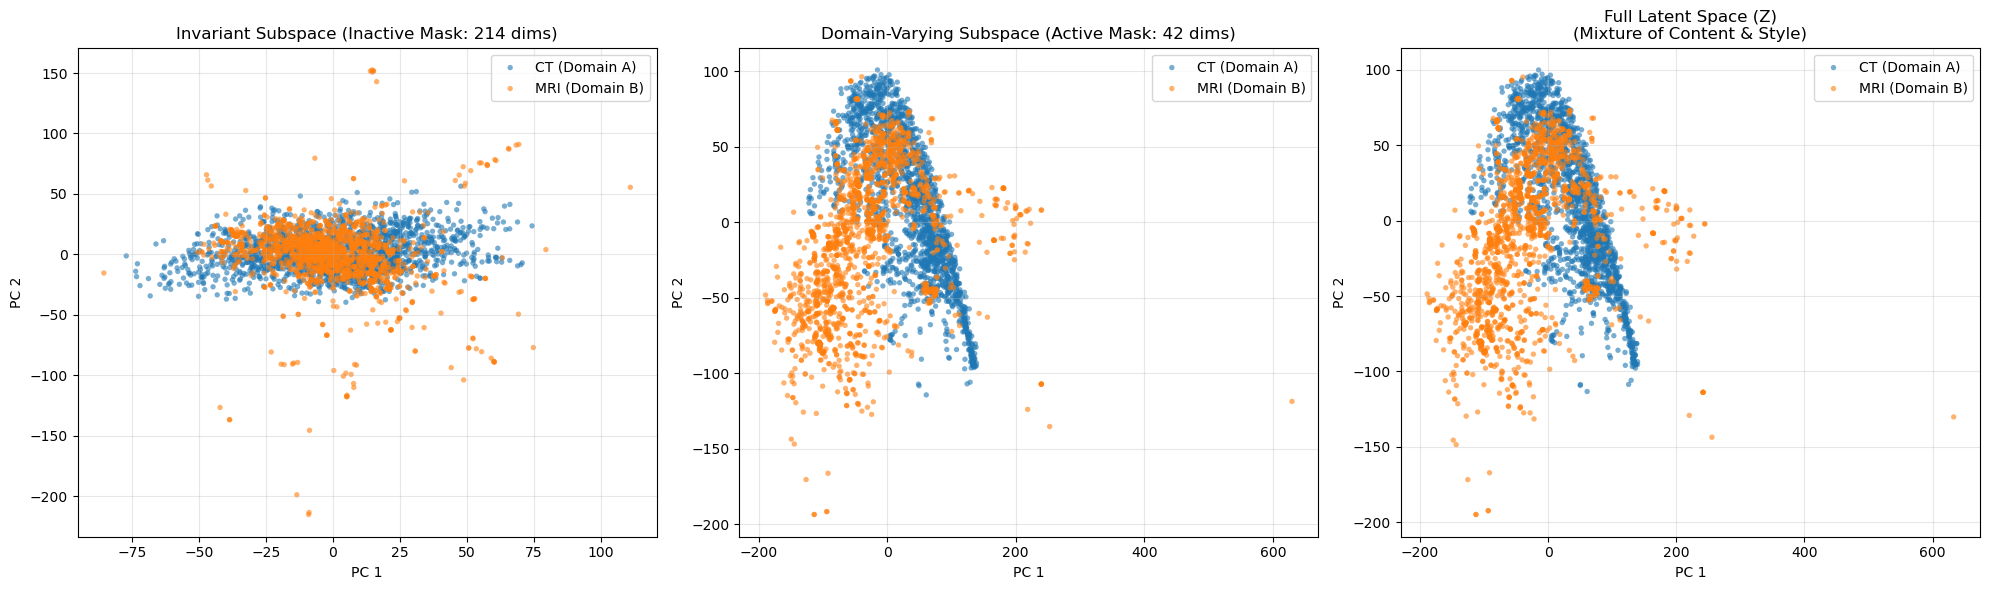

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_disentanglement(Z, y, active_mask, inactive_mask):
    """
    Plots the PCA projections of the Invariant, Variant, and Full subspaces.
    """
    Z_invariant = Z[:, inactive_mask] # Content 
    Z_variant = Z[:, active_mask]     # Style 
    
    pca_inv = PCA(n_components=2).fit_transform(Z_invariant)
    pca_var = PCA(n_components=2).fit_transform(Z_variant)
    pca_full = PCA(n_components=2).fit_transform(Z)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    labels = ['CT (Domain A)', 'MRI (Domain B)']
    colors = ['#1f77b4', '#ff7f0e'] # Blue, Orange
    alphas = [0.6, 0.6]

    ax = axes[0]
    for label_val, name, color, alpha in zip([0, 1], labels, colors, alphas):
        idx = (y == label_val)
        ax.scatter(pca_inv[idx, 0], pca_inv[idx, 1], c=color, label=name, alpha=alpha, s=15, edgecolor='none')
    
    ax.set_title(f"Invariant Subspace (Inactive Mask: {inactive_mask.sum()} dims)", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    ax = axes[1]
    for label_val, name, color, alpha in zip([0, 1], labels, colors, alphas):
        idx = (y == label_val)
        ax.scatter(pca_var[idx, 0], pca_var[idx, 1], c=color, label=name, alpha=alpha, s=15, edgecolor='none')
        
    ax.set_title(f"Domain-Varying Subspace (Active Mask: {active_mask.sum()} dims)", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    ax = axes[2]
    for label_val, name, color, alpha in zip([0, 1], labels, colors, alphas):
        idx = (y == label_val)
        ax.scatter(pca_full[idx, 0], pca_full[idx, 1], c=color, label=name, alpha=alpha, s=15, edgecolor='none')
        
    ax.set_title(f"Full Latent Space (Z)\n(Mixture of Content & Style)", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    plt.tight_layout()
    plt.show()

visualize_disentanglement(Z, y, active_mask, inactive_mask)
# plot 2 and 3 look identical because the SVD gives us an orthogonal
# basis. This is why when we do a full pca, the pca is identical to the
# domain varying pca since maximum varying eigendirections form the pca space

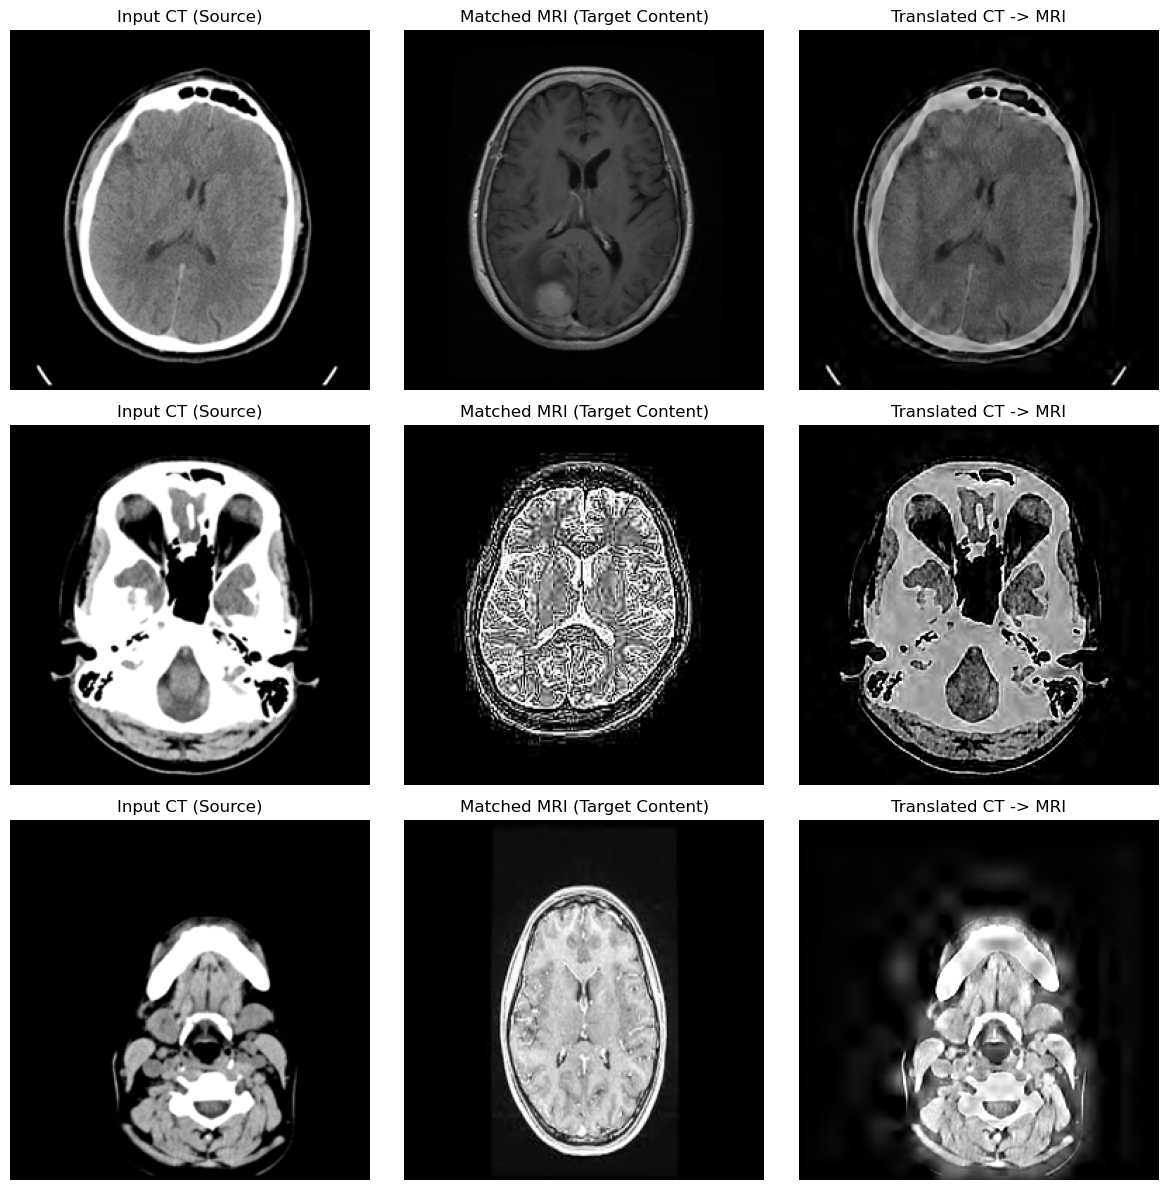

In [ ]:
from sklearn.neighbors import NearestNeighbors

indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def get_global_idx(subset_idx, domain):
    if domain == 'A': return indices_A[subset_idx]
    return indices_B[subset_idx]

# Fit Nearest Neighbor on INVARIANT (Content) subspace of Domain B
nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B[:, inactive_mask])

# --- 2. Histogram Matching Helper ---
def match_histograms_1d(source, template, mask_zeros=False):
    """
    Map source distribution to template distribution using Quantile Matching.
    """

    oldshape = source.shape
    source_flat = source.ravel()
    template_flat = template.ravel()
    if mask_zeros:
        # For Approximation band (Intensity), background is near 0.
        # We use a small epsilon to catch floating point 'zeros'
        eps = 1e-5
        mask_src = np.abs(source_flat) > eps
        mask_tmpl = np.abs(template_flat) > eps
    else:
        mask_src = np.ones(source_flat.shape, dtype=bool)
        mask_tmpl = np.ones(template_flat.shape, dtype=bool)
    
    if mask_src.sum() == 0 or mask_tmpl.sum() == 0:
        return source 
    
    # Extracting foreground
    s_values = source_flat[mask_src]
    t_values = template_flat[mask_tmpl]
    
    # quantile matching using onnly the foreground info
    s_indices = np.argsort(s_values)
    
    quantiles = np.linspace(0, 1, len(s_values))
    # Get values from template at these quantiles
    template_quantiles = np.interp(
        quantiles, 
        np.linspace(0, 1, len(t_values)), 
        np.sort(t_values)
    )
    
    matched = source_flat.copy()
    
    inverse_s_indices = np.argsort(s_indices)
    matched_foreground = template_quantiles[inverse_s_indices]
    
    matched[mask_src] = matched_foreground
    return matched.reshape(oldshape)

def translate_ct_to_mri(idx_A_local):
    # Match Content
    z_query = Z_A[idx_A_local]
    content_query = z_query[inactive_mask].reshape(1, -1)
    
    # Find MRI with closest anatomy
    dists, idxs = nbrs_B.kneighbors(content_query)
    idx_B_match = idxs[0][0]
    
    # Load Raw Wavelets (Dense)
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_match, 'B')
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()

    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    # We need to reconstruct the list-of-arrays format to access slices
    # We use a dummy rebuild to get the structure, then modify it in place
    # (Efficiency note: faster to map slices directly if we knew them perfectly, 
    # but using pywt helper is safer)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')
    
    # Style Transfer (Histogram Matching)
    # We create a new list for the output
    list_hybrid = []
    
    # Approximation (Low Freq / Contrast) -> Match Histograms
    # This forces CT gray levels to match MRI gray levels
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)
    
    # Details (High Freq / Texture) -> Match Histograms
    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        # detail_A is a tuple (H, V, D)
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            # Force CT noise/edges to have MRI statistics
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=True)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))
        
    # Reconstruct and Denormalize
    # Inverse Wavelet
    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)
    
    # matched the histograms in Z-score space.
    # Now need to project back to pixel space.
    # Since aligned distributions, the result is in the "MRI Z-score" space.
    # So using the MRI's (Target) mu/std to denormalize.
    
    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_match

test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    img_fake, idx_B = translate_ct_to_mri(idx_A)
    
    # Originals
    g_idx_A = get_global_idx(idx_A, 'A')
    g_idx_B = get_global_idx(idx_B, 'B')
    # re-open to get the clean original, bypassing the z-score/wavelet pipeline)
    path_A = df_meta.iloc[g_idx_A]['path']
    path_B = df_meta.iloc[g_idx_B]['path']
    
    img_A = Image.open(path_A).convert('L').resize(IMG_SIZE)
    img_B = Image.open(path_B).convert('L').resize(IMG_SIZE)
    
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_A, cmap='gray')
    plt.title("Input CT (Source)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_B, cmap='gray')
    plt.title("Matched MRI (Target Content)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake, cmap='gray')
    plt.title("Translated CT -> MRI")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

logits_A = model.decision_function(Z_A)
logits_B = model.decision_function(Z_B)

nt = len(logits_A)
nc = len(logits_B)    

sd_t = np.std(logits_A, ddof=1)
sd_c = np.std(logits_B, ddof=1)
s_pooled = np.sqrt(((nt - 1)*sd_t**2 + (nc - 1)*sd_c**2) / (nt + nc - 2))

max_B = np.max(logits_B)
min_A = np.min(logits_A)

# Caliper (Support Region)
# upper_bound = np.max(probs_B) + (caliper_sigma * np.std(probs_B))
# lower_bound = np.min(probs_A) - (caliper_sigma * np.std(probs_A))

# valid_mask_A = (probs_A >= lower_bound) & (probs_A <= upper_bound)
# valid_indices_A = np.where(valid_mask_A)[0]

# valid_mask_B = (probs_B >= lower_bound) & (probs_B <= upper_bound)
# valid_indices_B = np.where(valid_mask_B)[0]

# print(f"Caliper retained {len(valid_indices_A)}/{len(Z_A)} CTs and {len(valid_indices_B)}/{len(Z_B)} MRIs.")

rg = 0.5  # caliper width in pooled SD units (0.5 is what you used before)

upper_allow_for_A = max_B + rg * s_pooled   # drop CTs with logits above this
lower_allow_for_B = min_A - rg * s_pooled   # drop MRIs with logits below this

print(min_A, max_B, s_pooled)

-10.4781685 13.450105 2.2484093


Kept CT:  1742/1742  (dropped 0)
Kept MRI: 1743/1744  (dropped 1)


/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:188: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-1037.459261125057537 > -1041.903205853014697). You may want to try with a higher value of support_fraction (current value: 0.532).
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:188: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-924.713990296259226 > -927.545793402579079). You may want to try with a higher value of support_fraction (current value: 0.532).
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:188: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-922.857384962201877 > -924.073181548554544). You may want to try with a higher 

Metric: Robust MinCovDet


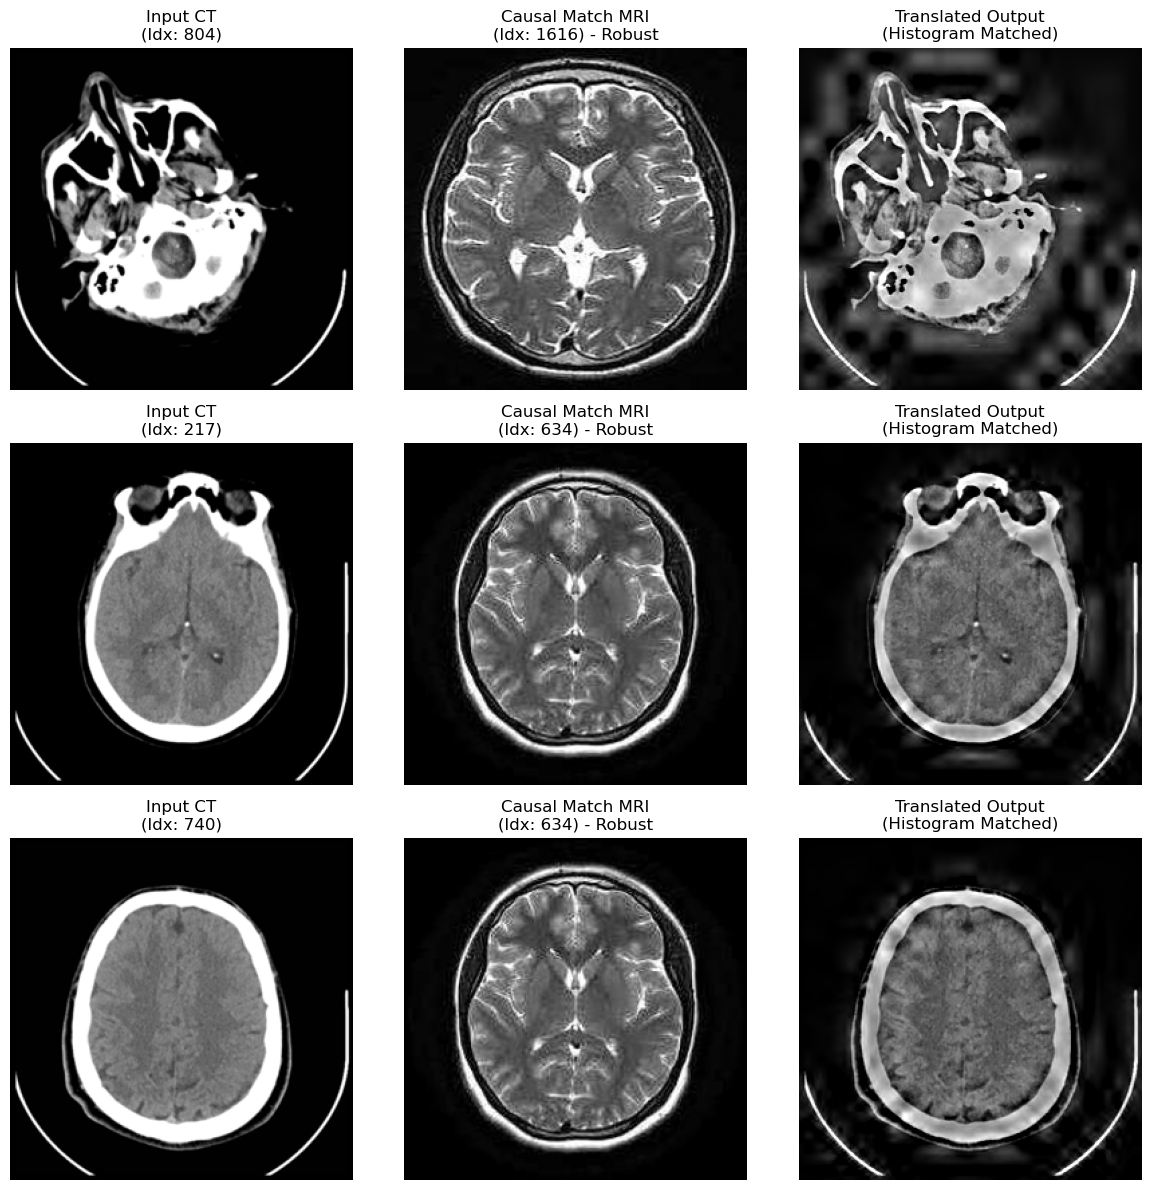

In [15]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.spatial.distance import cdist

indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

# wavelet shape info using a dummy image
dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def get_global_idx(subset_idx, domain):
    if domain == 'A': return indices_A[subset_idx]
    return indices_B[subset_idx]

def match_histograms_1d(source, template, mask_zeros=False):
    """
    Map source distribution to template distribution using Quantile Matching.
    """
    oldshape = source.shape
    source_flat = source.ravel()
    template_flat = template.ravel()
    
    if mask_zeros:
        eps = 1e-5
        mask_src = np.abs(source_flat) > eps
        mask_tmpl = np.abs(template_flat) > eps
    else:
        mask_src = np.ones(source_flat.shape, dtype=bool)
        mask_tmpl = np.ones(template_flat.shape, dtype=bool)
    
    if mask_src.sum() == 0 or mask_tmpl.sum() == 0:
        return source 
    
    s_values = source_flat[mask_src]
    t_values = template_flat[mask_tmpl]
    
    s_indices = np.argsort(s_values)
    quantiles = np.linspace(0, 1, len(s_values))
    template_quantiles = np.interp(
        quantiles, 
        np.linspace(0, 1, len(t_values)), 
        np.sort(t_values)
    )
    
    matched = source_flat.copy()
    inverse_s_indices = np.argsort(s_indices)
    matched_foreground = template_quantiles[inverse_s_indices]
    matched[mask_src] = matched_foreground
    
    return matched.reshape(oldshape)

def build_causal_matching_map(Z_A, Z_B, inactive_mask, model, caliper_sigma=2.0):
    """
    Returns a mapping: { local_idx_A : local_idx_B }
    using Propensity Calipers and Mahalanobis Distance on Invariants.
    """
    # Propensity score 
    # probs_A = model.predict_proba(Z_A)[:, 1]
    # probs_B = model.predict_proba(Z_B)[:, 1]
    logits_A = model.decision_function(Z_A)
    logits_B = model.decision_function(Z_B)
    
    nt = len(logits_A)
    nc = len(logits_B)    
 
    sd_t = np.std(logits_A, ddof=1)
    sd_c = np.std(logits_B, ddof=1)
    s_pooled = np.sqrt(((nt - 1)*sd_t**2 + (nc - 1)*sd_c**2) / (nt + nc - 2))

    max_B = np.max(logits_B)
    min_A = np.min(logits_A)
    
    # Caliper (Support Region)
    # upper_bound = np.max(probs_B) + (caliper_sigma * np.std(probs_B))
    # lower_bound = np.min(probs_A) - (caliper_sigma * np.std(probs_A))
    
    # valid_mask_A = (probs_A >= lower_bound) & (probs_A <= upper_bound)
    # valid_indices_A = np.where(valid_mask_A)[0]
    
    # valid_mask_B = (probs_B >= lower_bound) & (probs_B <= upper_bound)
    # valid_indices_B = np.where(valid_mask_B)[0]
    
    # print(f"Caliper retained {len(valid_indices_A)}/{len(Z_A)} CTs and {len(valid_indices_B)}/{len(Z_B)} MRIs.")

    rg = 0.5  # caliper width in pooled SD units (0.5 is what you used before)

    upper_allow_for_A = max_B + rg * s_pooled   # drop CTs with logits above this
    lower_allow_for_B = min_A - rg * s_pooled   # drop MRIs with logits below this

    keep_A = logits_A <= upper_allow_for_A
    keep_B = logits_B >= lower_allow_for_B

    valid_indices_A = np.where(keep_A)[0]  # local indices into Z_A
    valid_indices_B = np.where(keep_B)[0]  # local indices into Z_B

    print(f"Kept CT:  {keep_A.sum()}/{len(keep_A)}  (dropped {len(keep_A)-keep_A.sum()})")
    print(f"Kept MRI: {keep_B.sum()}/{len(keep_B)}  (dropped {len(keep_B)-keep_B.sum()})")


    # Robust Covariance (Metric Learning)
    Z_A_inv = Z_A[:, inactive_mask]
    Z_B_inv = Z_B[:, inactive_mask]
    pool_inv = np.concatenate([Z_A_inv[valid_indices_A], Z_B_inv[valid_indices_B]], axis=0)
    
    try:
        # Downsample for speed if needed
        if len(pool_inv) > 5000:
            subset_idx = np.random.choice(len(pool_inv), 5000, replace=False)
            cov_estimator = MinCovDet().fit(pool_inv[subset_idx])
        else:
            cov_estimator = MinCovDet().fit(pool_inv)
        print("Metric: Robust MinCovDet")
    except:
        cov_estimator = EmpiricalCovariance().fit(pool_inv)
        print("Metric: Standard Empirical Covariance (Fallback)")
        
    VI = cov_estimator.precision_ 

    # Distance Matrix calculation
    dist_matrix = cdist(
        Z_A_inv[valid_indices_A], 
        Z_B_inv[valid_indices_B], 
        metric='mahalanobis', 
        VI=VI
    )
    
    # Matching
    min_indices = np.argmin(dist_matrix, axis=1)
    # IMP: We are performing 'greedy' matching in some sense here.
    # Every element is getting mapped to its nearest neighbor in the sense of 
    # propensity score using distances on the invariant set. This is not how
    # we do things for estimation of ATT; however for style trasnfer style method
    # this is superior.  
    
    # Construct the Map
    matching_map = {}
    for i, match_idx_rel in enumerate(min_indices):
        idx_A = valid_indices_A[i]
        idx_B = valid_indices_B[match_idx_rel]
        matching_map[idx_A] = idx_B
        
    return matching_map

robust_map = build_causal_matching_map(Z_A, Z_B, inactive_mask, model)

# Fallback for dropped CTs: Standard Euclidean NN on Invariants
fallback_nbrs = NearestNeighbors(n_neighbors=1).fit(Z_B[:, inactive_mask])

def translate_ct_to_mri(idx_A_local):
    """
    Translate CT -> MRI using Causal Matching + Wavelet Histogram Injection.
    """
    
    if idx_A_local in robust_map:
        # Use the Robust Mahalanobis match
        idx_B_match = robust_map[idx_A_local]
        method = "Robust"
    else:
        # Fallback (if filtered by caliper)
        # We find the closest Euclidean neighbor just to prevent crashing
        content_query = Z_A[idx_A_local, inactive_mask].reshape(1, -1)
        _, idxs = fallback_nbrs.kneighbors(content_query)
        idx_B_match = idxs[0][0]
        method = "Fallback"

    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_match, 'B')
    
    # Fetch sparse vectors and densify
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()

    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')
    
    # style injection via histogram matching
    list_hybrid = []

    # Mask zeros to avoid matching the black background
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)
    
    # Detail Bands (Texture)
    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=True)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))
        
    # RECONSTRUCTION
    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)
    
    # Denormalize using TARGET (MRI) statistics
    # This ensures the pixel intensity range matches the MRI domain
    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    
    # Post-processing
    recon = np.clip(recon, 0, 255).astype('uint8')
    
    return recon, idx_B_match, method

valid_keys = list(robust_map.keys())
test_indices = np.random.choice(valid_keys, 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    img_fake, idx_B, method_used = translate_ct_to_mri(idx_A)

    g_idx_A = get_global_idx(idx_A, 'A')
    g_idx_B = get_global_idx(idx_B, 'B')
    
    path_A = df_meta.iloc[g_idx_A]['path']
    path_B = df_meta.iloc[g_idx_B]['path']
    
    img_A = Image.open(path_A).convert('L').resize(IMG_SIZE)
    img_B = Image.open(path_B).convert('L').resize(IMG_SIZE)
    
    # Plot
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_A, cmap='gray')
    plt.title(f"Input CT\n(Idx: {idx_A})")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_B, cmap='gray')
    plt.title(f"Causal Match MRI\n(Idx: {idx_B}) - {method_used}")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake, cmap='gray')
    plt.title("Translated Output\n(Histogram Matched)")
    plt.axis('off')

plt.tight_layout()
plt.show()

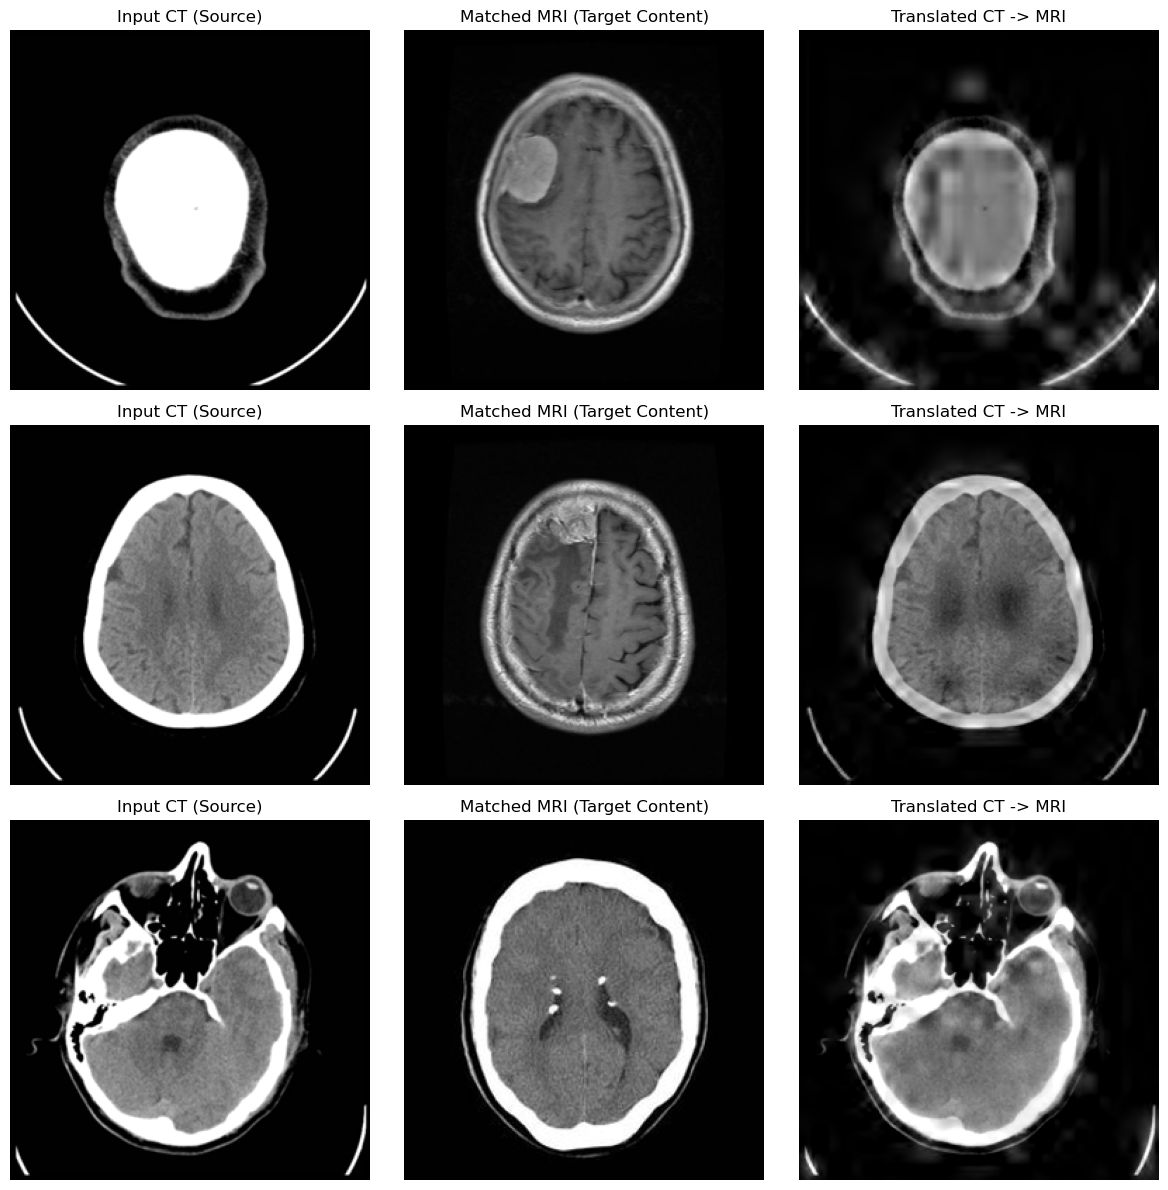

In [ ]:
from sklearn.neighbors import NearestNeighbors

indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B[:, inactive_mask])
test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    img_fake, idx_B = translate_ct_to_mri(idx_A)
    
    g_idx_A = get_global_idx(idx_A, 'A')
    g_idx_B = get_global_idx(idx_B, 'B')
    path_A = df_meta.iloc[g_idx_A]['path']
    path_B = df_meta.iloc[g_idx_B]['path']
    
    img_A = Image.open(path_A).convert('L').resize(IMG_SIZE)
    img_B = Image.open(path_B).convert('L').resize(IMG_SIZE)
    
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_A, cmap='gray')
    plt.title("Input CT (Source)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_B, cmap='gray')
    plt.title("Matched MRI (Target Content)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake, cmap='gray')
    plt.title("Translated CT -> MRI")
    plt.axis('off')

plt.tight_layout()
plt.show()

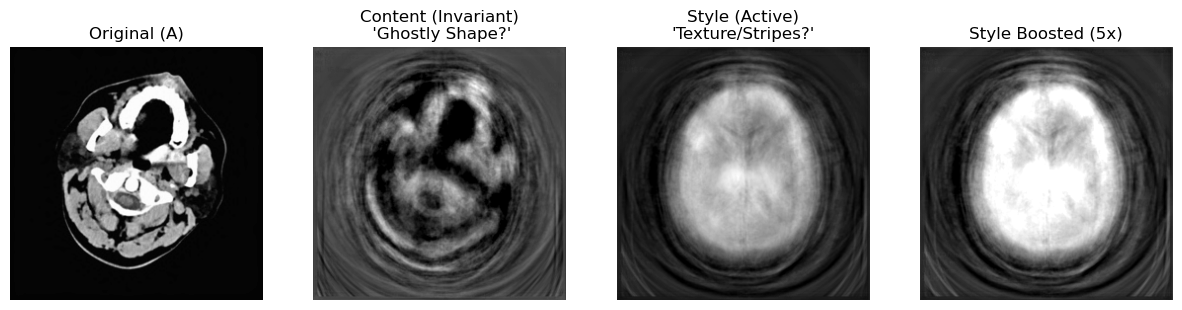

In [16]:
idx = np.random.choice(len(df_meta)) 
z_sample = Z[idx]
original_shape = IMG_SIZE

z_content = z_sample.copy()
z_content[active_mask] = 0  
# Zeroing out style (domain-variant), keep content (domain invariant)

z_style = z_sample.copy()
z_style[inactive_mask] = 0  # Zero out content, keep style

# Inverting SVD to get back to Wavelet Space
# shape: (1, n_features)
w_content = svd.inverse_transform(z_content.reshape(1, -1))
w_style = svd.inverse_transform(z_style.reshape(1, -1))

# img_content = reconstruct_image_from_vector(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape)
# img_style = reconstruct_image_from_vector(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape)
# img_original = reconstruct_image_from_vector(W[idx], coeff_slices, original_shape, coeff_shape)

img_content = reconstruct_image_with_denorm(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_style = reconstruct_image_with_denorm(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_original = reconstruct_image_with_denorm(W[idx], coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_original, cmap='gray')
plt.title(f"Original ({df_meta.iloc[idx]['domain']})")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_content, cmap='gray')
plt.title("Content (Invariant)\n 'Ghostly Shape?'")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_style, cmap='gray')
plt.title("Style (Active)\n'Texture/Stripes?'")
plt.axis('off')

plt.subplot(1, 4, 4)
# Visualizing Style Enhanced (Contrast boosted)
plt.imshow(np.clip(img_style * 2.0, 0, 255).astype('uint8'), cmap='gray') 
plt.title("Style Boosted (5x)")
plt.axis('off')

plt.show()

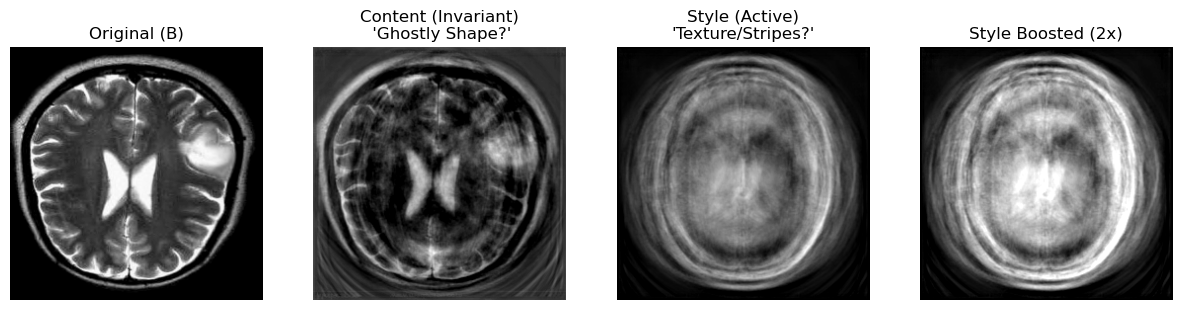

In [17]:
idx = np.random.choice(len(df_meta)) 
z_sample = Z[idx]
original_shape = IMG_SIZE

z_content = z_sample.copy()
z_content[active_mask] = 0  
# Zeroing out style (domain-variant), keep content (domain invariant)

z_style = z_sample.copy()
z_style[inactive_mask] = 0  # Zero out content, keep style

# Inverting SVD to get back to Wavelet Space
# shape: (1, n_features)
w_content = svd.inverse_transform(z_content.reshape(1, -1))
w_style = svd.inverse_transform(z_style.reshape(1, -1))

# img_content = reconstruct_image_from_vector(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape)
# img_style = reconstruct_image_from_vector(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape)
# img_original = reconstruct_image_from_vector(W[idx], coeff_slices, original_shape, coeff_shape)

img_content = reconstruct_image_with_denorm(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_style = reconstruct_image_with_denorm(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_original = reconstruct_image_with_denorm(W[idx], coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_original, cmap='gray')
plt.title(f"Original ({df_meta.iloc[idx]['domain']})")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_content, cmap='gray')
plt.title("Content (Invariant)\n 'Ghostly Shape?'")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_style, cmap='gray')
plt.title("Style (Active)\n'Texture/Stripes?'")
plt.axis('off')

plt.subplot(1, 4, 4)
# Visualizing Style Enhanced (Contrast boosted)
plt.imshow(np.clip(img_style * 2.0, 0, 255).astype('uint8'), cmap='gray') 
plt.title("Style Boosted (2x)")
plt.axis('off')

plt.show()

### Abalation 

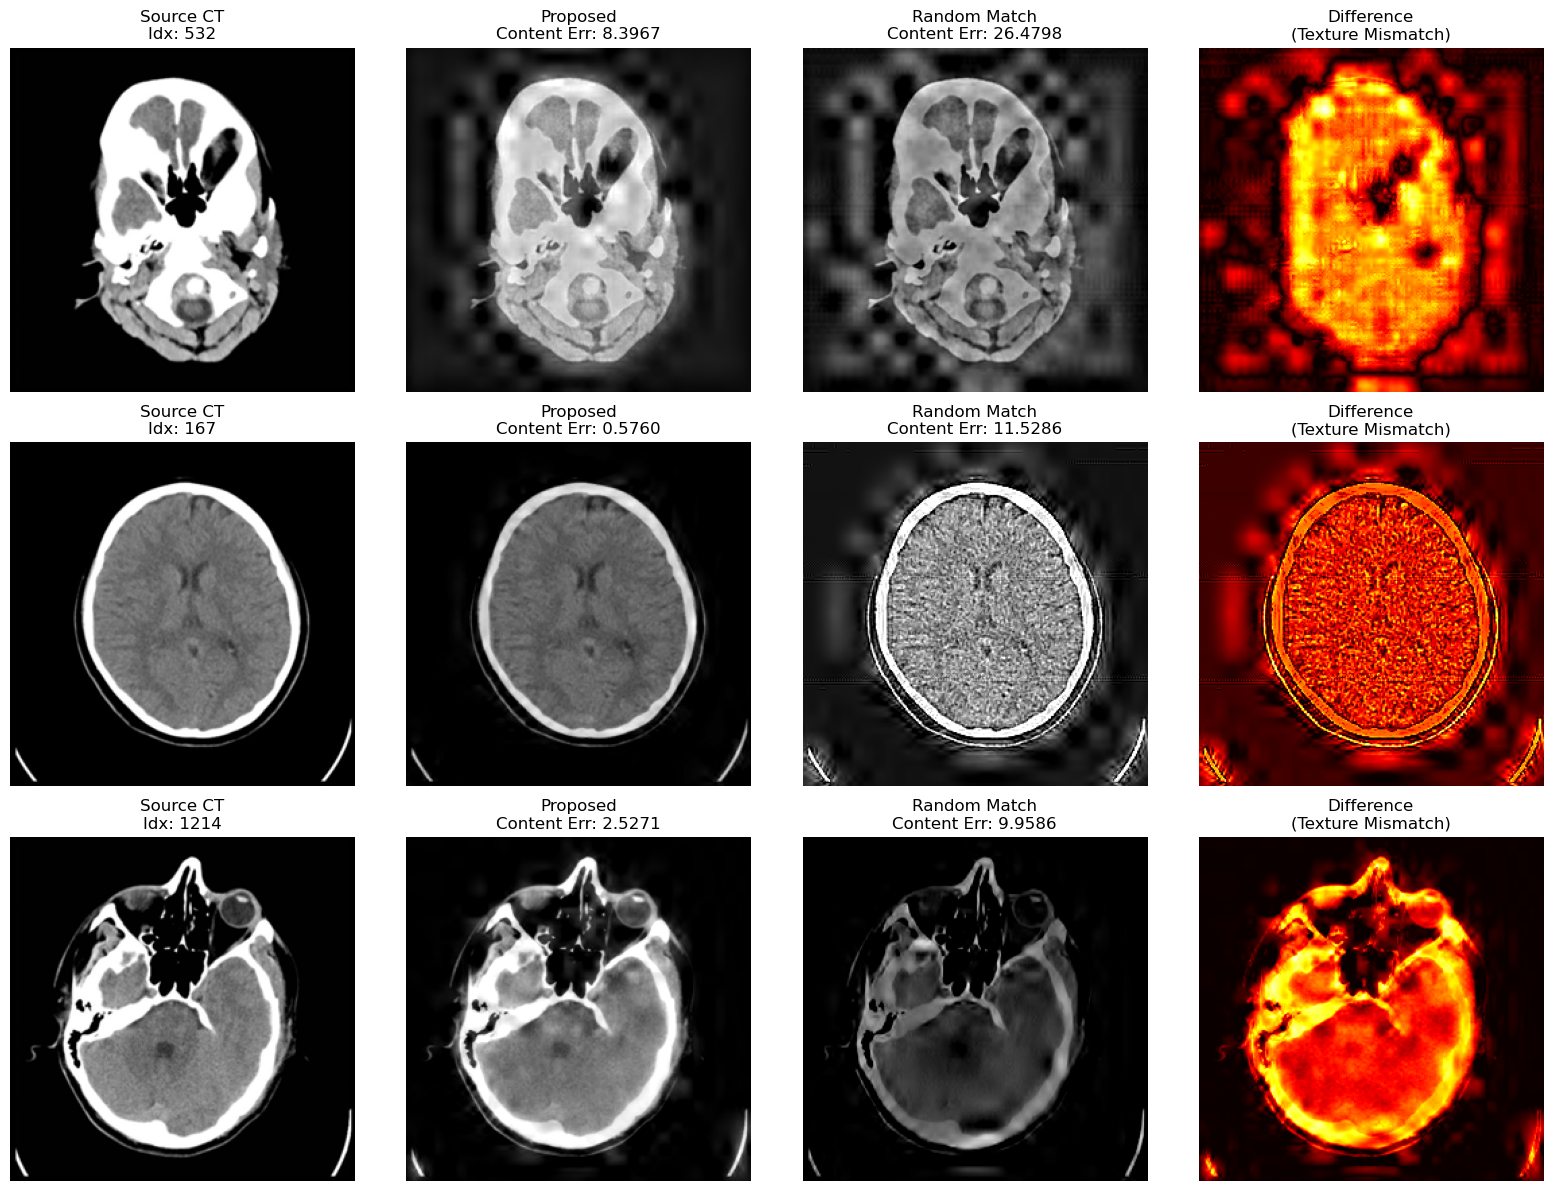

Mean Content Error (Proposed): 3.8333
Mean Content Error (Random):   15.9890


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
from scipy import sparse

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def translate_ct_to_mri_random(idx_A_local):
    idx_B_random = np.random.choice(len(Z_B))
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_random, 'B') # Using Random B
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')

    list_hybrid = []
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)

    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=False)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))

    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)

    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_random

def calculate_content_error(img_generated, z_source_content):
    """
    Project generated image back to Z space and measure distance 
    to original source in the INVARIANT subspace.
    """
    # Project Image -> Wavelet -> Sparse Vector
    img_arr = np.array(Image.fromarray(img_generated).resize(IMG_SIZE).convert('L'))
    
    # normalize using the same stats logic? 
    # SVD expects z-scored inputs?
    mu, std = img_arr.mean(), img_arr.std() + 1e-8
    img_norm = (img_arr - mu) / std
    
    coeffs = pywt.wavedec2(img_norm, wavelet=WAVELET_TYPE, level=LEVEL)
    coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1)
    
    # Thresholding 
    k = int(np.floor((1 - KEEP_RATIO) * flat.size))
    thresh = np.partition(np.abs(flat), k)[k]
    flat[np.abs(flat) <= thresh] = 0.0
    
    vec_sparse = sparse.csr_matrix(flat)
    z_new = svd.transform(vec_sparse)
    z_new_content = z_new[:, inactive_mask]

    mse = np.mean((z_new_content - z_source_content)**2)
    return mse

test_indices = np.random.choice(len(Z_A), 3, replace=False)
fig, axes = plt.subplots(len(test_indices), 4, figsize=(16, 4 * len(test_indices)))
if len(test_indices) == 1: axes = [axes]

cols = ["Source CT", "Proposed (Causal Match)", "Random Match (Ablation)", "Difference (Proposed vs Random)"]

errors_proposed = []
errors_random = []

for i, idx_A in enumerate(test_indices):
    img_proposed, idx_B_prop = translate_ct_to_mri(idx_A) 
    img_random, idx_B_rand = translate_ct_to_mri_random(idx_A)
    
    g_idx_A = get_global_idx(idx_A, 'A')
    img_A = Image.open(df_meta.iloc[g_idx_A]['path']).convert('L').resize(IMG_SIZE)
    z_src_content = Z_A[idx_A][inactive_mask].reshape(1, -1)
    
    err_p = calculate_content_error(img_proposed, z_src_content)
    err_r = calculate_content_error(img_random, z_src_content)
    
    errors_proposed.append(err_p)
    errors_random.append(err_r)
    
    axes[i][0].imshow(img_A, cmap='gray')
    axes[i][0].set_title(f"Source CT\nIdx: {idx_A}")
    
    axes[i][1].imshow(img_proposed, cmap='gray')
    axes[i][1].set_title(f"Proposed\nContent Err: {err_p:.4f}")
    
    axes[i][2].imshow(img_random, cmap='gray')
    axes[i][2].set_title(f"Random Match\nContent Err: {err_r:.4f}")
    
    # Difference Map 
    diff = np.abs(img_proposed.astype(float) - img_random.astype(float))
    axes[i][3].imshow(diff, cmap='hot')
    axes[i][3].set_title(f"Difference\n(Texture Mismatch)")

    for ax in axes[i]: ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean Content Error (Proposed): {np.mean(errors_proposed):.4f}")
print(f"Mean Content Error (Random):   {np.mean(errors_random):.4f}")

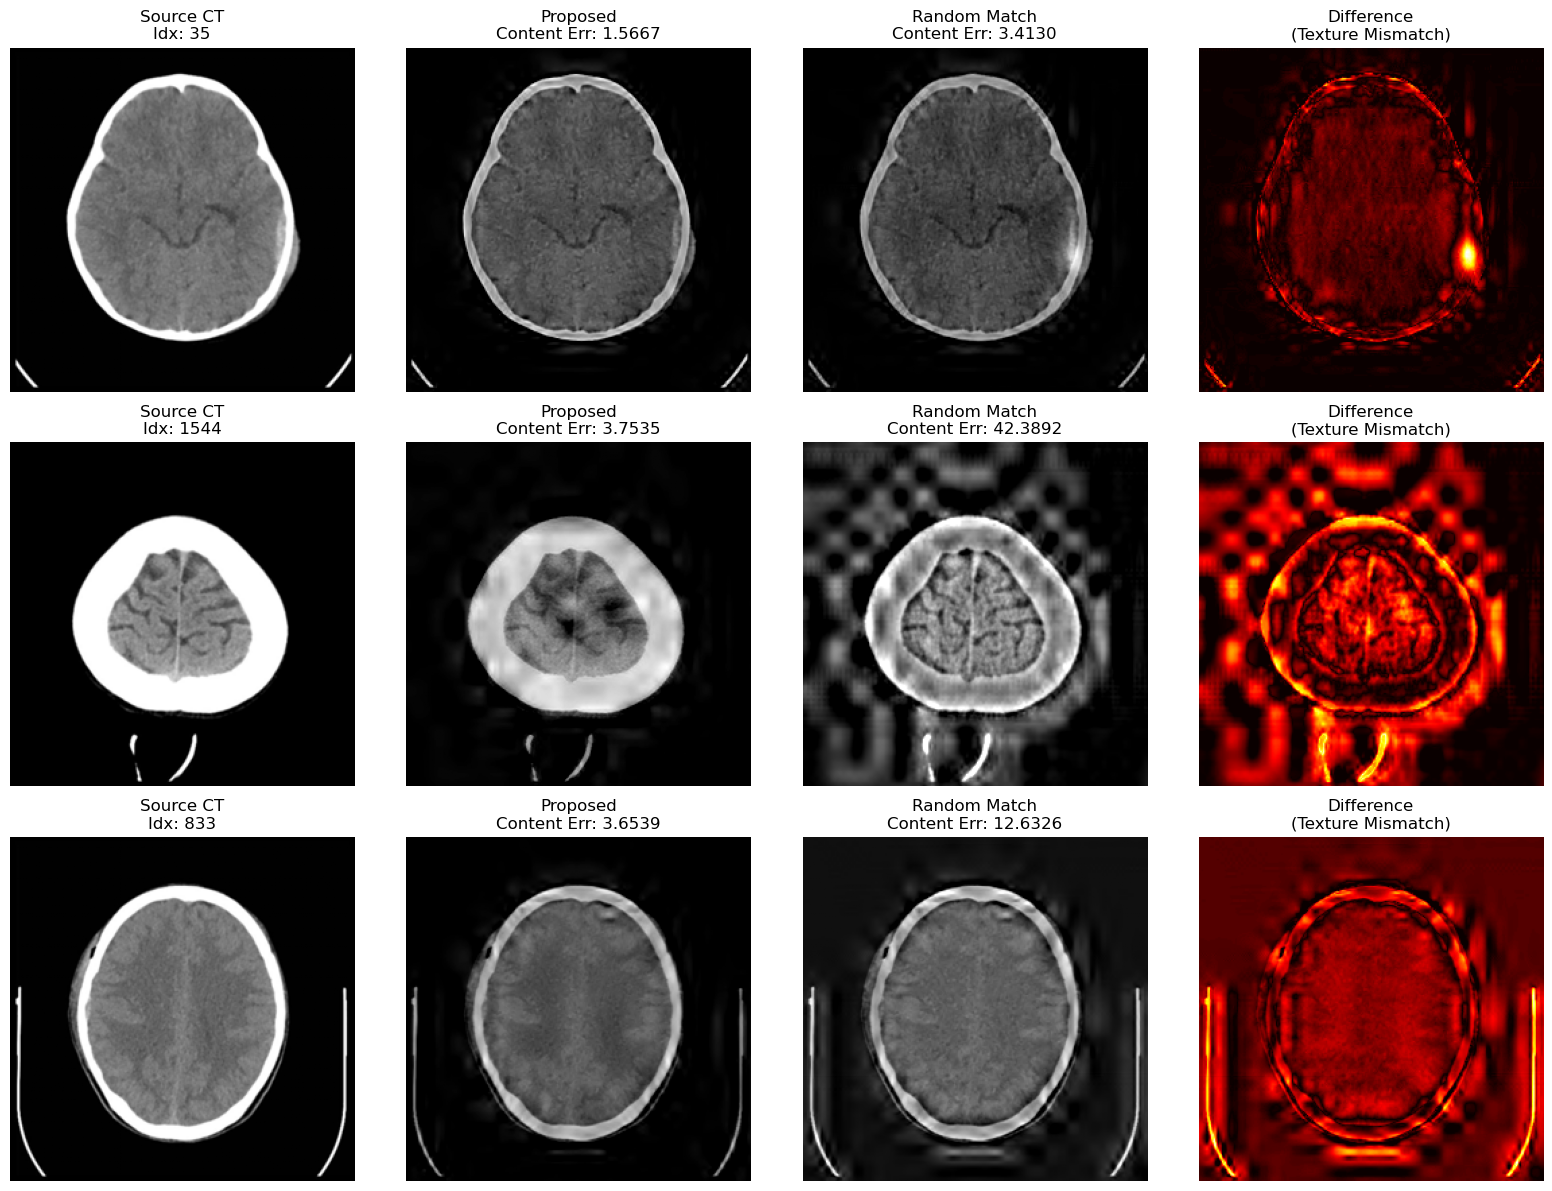

Mean Content Error (Proposed): 2.9914
Mean Content Error (Random):   19.4783


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
from scipy import sparse

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def translate_ct_to_mri_random(idx_A_local):
    idx_B_random = np.random.choice(len(Z_B))
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_random, 'B') # Using Random B
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')

    list_hybrid = []
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)

    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=False)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))

    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)

    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_random

def calculate_content_error(img_generated, z_source_content):
    """
    Project generated image back to Z space and measure distance 
    to original source in the INVARIANT subspace.
    """
    # Project Image -> Wavelet -> Sparse Vector
    img_arr = np.array(Image.fromarray(img_generated).resize(IMG_SIZE).convert('L'))
    
    # normalize using the same stats logic? 
    # SVD expects z-scored inputs?
    mu, std = img_arr.mean(), img_arr.std() + 1e-8
    img_norm = (img_arr - mu) / std
    
    coeffs = pywt.wavedec2(img_norm, wavelet=WAVELET_TYPE, level=LEVEL)
    coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1)
    
    # Thresholding 
    k = int(np.floor((1 - KEEP_RATIO) * flat.size))
    thresh = np.partition(np.abs(flat), k)[k]
    flat[np.abs(flat) <= thresh] = 0.0
    
    vec_sparse = sparse.csr_matrix(flat)
    z_new = svd.transform(vec_sparse)
    z_new_content = z_new[:, inactive_mask]

    mse = np.mean((z_new_content - z_source_content)**2)
    return mse

test_indices = np.random.choice(len(Z_A), 3, replace=False)
fig, axes = plt.subplots(len(test_indices), 4, figsize=(16, 4 * len(test_indices)))
if len(test_indices) == 1: axes = [axes]

cols = ["Source CT", "Proposed (Causal Match)", "Random Match (Ablation)", "Difference (Proposed vs Random)"]

errors_proposed = []
errors_random = []

for i, idx_A in enumerate(test_indices):
    img_proposed, idx_B_prop = translate_ct_to_mri(idx_A) # Your working function
    img_random, idx_B_rand = translate_ct_to_mri_random(idx_A)
    
    g_idx_A = get_global_idx(idx_A, 'A')
    img_A = Image.open(df_meta.iloc[g_idx_A]['path']).convert('L').resize(IMG_SIZE)
    z_src_content = Z_A[idx_A][inactive_mask].reshape(1, -1)
    
    err_p = calculate_content_error(img_proposed, z_src_content)
    err_r = calculate_content_error(img_random, z_src_content)
    
    errors_proposed.append(err_p)
    errors_random.append(err_r)
    
    axes[i][0].imshow(img_A, cmap='gray')
    axes[i][0].set_title(f"Source CT\nIdx: {idx_A}")
    
    axes[i][1].imshow(img_proposed, cmap='gray')
    axes[i][1].set_title(f"Proposed\nContent Err: {err_p:.4f}")
    
    axes[i][2].imshow(img_random, cmap='gray')
    axes[i][2].set_title(f"Random Match\nContent Err: {err_r:.4f}")
    
    # Difference Map 
    diff = np.abs(img_proposed.astype(float) - img_random.astype(float))
    axes[i][3].imshow(diff, cmap='hot')
    axes[i][3].set_title(f"Difference\n(Texture Mismatch)")

    for ax in axes[i]: ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean Content Error (Proposed): {np.mean(errors_proposed):.4f}")
print(f"Mean Content Error (Random):   {np.mean(errors_random):.4f}")

In [ ]:
import torch
import torchvision.transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance
from PIL import Image
from tqdm import tqdm
import numpy as np

NUM_SAMPLES = 500   
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

# Preprocessing (Standard for FID-2048)
preprocess = T.Compose([
    T.Resize((299, 299)),
    T.PILToTensor(),        # uint8 [0-255]
    T.Lambda(lambda x: x.repeat(3, 1, 1)) # Grayscale to 3-channel
])

def get_mri_batch_from_disk(subset_indices):
    """Loads Real MRIs"""
    images = []
    for idx in subset_indices:
        global_idx = get_global_idx(idx, 'B')
        path = df_meta.iloc[global_idx]['path']
        img = Image.open(path).convert('L')
        images.append(preprocess(img))
    return torch.stack(images).to(DEVICE)

def get_fake_batch_from_gen(subset_indices):
    """Generates Fake MRIs from CTs"""
    images = []
    for idx in subset_indices:
        # Translate CT (A) -> MRI (B)
        img_np, _ = translate_ct_to_mri(idx)
        img_pil = Image.fromarray(img_np.astype('uint8'))
        images.append(preprocess(img_pil))
    return torch.stack(images).to(DEVICE)


print(f"Initializing Standard FID-2048 on {DEVICE}...")
fid = FrechetInceptionDistance(feature=2048, normalize=True).to(DEVICE)


shuffled_B = np.random.permutation(len(Z_B))
real_split_1 = shuffled_B[:NUM_SAMPLES]            # For Baseline & Target
real_split_2 = shuffled_B[NUM_SAMPLES:NUM_SAMPLES*2] # For Baseline comparison

indices_A_sample = np.random.choice(len(Z_A), NUM_SAMPLES, replace=False)

# Baseline (Real vs Real) 
print(f"Baseline (Real MRI vs Real MRI)")
fid.reset()

for i in tqdm(range(0, len(real_split_1), BATCH_SIZE)):
    batch_1 = get_mri_batch_from_disk(real_split_1[i:i+BATCH_SIZE])
    fid.update(batch_1, real=True)

for i in tqdm(range(0, len(real_split_2), BATCH_SIZE)):
    batch_2 = get_mri_batch_from_disk(real_split_2[i:i+BATCH_SIZE])
    fid.update(batch_2, real=False) #

baseline_score = fid.compute().item()
print(f"Baseline FID (Perfect Score): {baseline_score:.4f}")

print(f"\n Model FID (Real MRI vs Translated CT)")
fid.reset()

for i in tqdm(range(0, len(real_split_1), BATCH_SIZE)):
    batch_real = get_mri_batch_from_disk(real_split_1[i:i+BATCH_SIZE])
    fid.update(batch_real, real=True)

for i in tqdm(range(0, len(indices_A_sample), BATCH_SIZE)):
    batch_fake = get_fake_batch_from_gen(indices_A_sample[i:i+BATCH_SIZE])
    fid.update(batch_fake, real=False)

model_score = fid.compute().item()

print(f"==========================================")
print(f"Baseline FID (Real vs Real): {baseline_score:.4f}")
print(f"Model FID    (Real vs Fake): {model_score:.4f}")
print(f"Gap: {model_score - baseline_score:.4f}")
print(f"==========================================")

Initializing Standard FID-2048 on cuda...
--- Step 1: Calculating Baseline (Real MRI vs Real MRI) ---


100%|██████████| 16/16 [00:00<00:00, 21.48it/s]


Baseline FID (Perfect Score): 28.1769

--- Step 2: Calculating Model FID (Real MRI vs Translated CT) ---


100%|██████████| 16/16 [00:01<00:00, 11.32it/s]


Baseline FID (Real vs Real): 28.1769
Model FID    (Real vs Fake): 169.6167
Gap: 141.4399


In [22]:
import torch
import torchvision.transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance
from PIL import Image
from tqdm import tqdm
import numpy as np

NUM_SAMPLES = 500   
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

# Preprocessing (Standard for FID-2048)
preprocess = T.Compose([
    T.Resize((299, 299)),
    T.PILToTensor(),        # uint8 [0-255]
    T.Lambda(lambda x: x.repeat(3, 1, 1)) # Grayscale to 3-channel
])

def get_mri_batch_from_disk(subset_indices):
    """Loads Real MRIs"""
    images = []
    for idx in subset_indices:
        global_idx = get_global_idx(idx, 'B')
        path = df_meta.iloc[global_idx]['path']
        img = Image.open(path).convert('L')
        images.append(preprocess(img))
    return torch.stack(images).to(DEVICE)

def get_fake_batch_from_gen(subset_indices):
    """Generates Fake MRIs from CTs"""
    images = []
    for idx in subset_indices:
        img_np, _, _ = translate_ct_to_mri(idx)
        
        img_pil = Image.fromarray(img_np.astype('uint8'))
        images.append(preprocess(img_pil))
    return torch.stack(images).to(DEVICE)

print(f"Initializing Standard FID-2048 on {DEVICE}...")
fid = FrechetInceptionDistance(feature=2048, normalize=True).to(DEVICE)

# Prepare Real MRI Splits (Baseline)
shuffled_B = np.random.permutation(len(Z_B))
real_split_1 = shuffled_B[:NUM_SAMPLES]            
real_split_2 = shuffled_B[NUM_SAMPLES:NUM_SAMPLES*2] 

# Sample only from VALID Robust Matches
valid_robust_indices = list(robust_map.keys())

actual_num_samples = min(NUM_SAMPLES, len(valid_robust_indices))
indices_A_sample = np.random.choice(valid_robust_indices, actual_num_samples, replace=False)

print(f"Evaluating on {actual_num_samples} robustly matched samples.")

print(f"Baseline (Real MRI vs Real MRI)")
fid.reset()

for i in tqdm(range(0, len(real_split_1), BATCH_SIZE)):
    batch_1 = get_mri_batch_from_disk(real_split_1[i:i+BATCH_SIZE])
    fid.update(batch_1, real=True)

for i in tqdm(range(0, len(real_split_2), BATCH_SIZE)):
    batch_2 = get_mri_batch_from_disk(real_split_2[i:i+BATCH_SIZE])
    fid.update(batch_2, real=False)

baseline_score = fid.compute().item()
print(f"Baseline FID (Perfect Score): {baseline_score:.4f}")

print(f"\nModel FID (Real MRI vs Robustly Translated CT)")
fid.reset()

# Load Real Distribution (Target)
for i in tqdm(range(0, len(real_split_1), BATCH_SIZE)):
    batch_real = get_mri_batch_from_disk(real_split_1[i:i+BATCH_SIZE])
    fid.update(batch_real, real=True)

# Generate Fake Distribution (Source)
for i in tqdm(range(0, len(indices_A_sample), BATCH_SIZE)):
    batch_fake = get_fake_batch_from_gen(indices_A_sample[i:i+BATCH_SIZE])
    fid.update(batch_fake, real=False)

model_score = fid.compute().item()

print(f"Baseline FID (Real vs Real): {baseline_score:.4f}")
print(f"Model FID    (Real vs Fake): {model_score:.4f}")
print(f"Gap: {model_score - baseline_score:.4f}")


Initializing Standard FID-2048 on cuda...
Evaluating on 500 robustly matched samples.
Baseline (Real MRI vs Real MRI)


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 21.14it/s]


Baseline FID (Perfect Score): 28.0749

Model FID (Real MRI vs Robustly Translated CT)


100%|██████████| 16/16 [00:01<00:00, 13.42it/s]


Baseline FID (Real vs Real): 28.0749
Model FID    (Real vs Fake): 175.2485
Gap: 147.1736


In [21]:
from skimage.metrics import structural_similarity as ssim_metric
import numpy as np
from PIL import Image
from tqdm import tqdm

def calculate_robust_ssim(num_samples=200):
    """
    Computes SSIM on the Robustly Matched subset.
    Returns both Standard SSIM and Inverted SSIM.
    """
    standard_scores = []
    inverted_scores = []
    
    # Sample only from VALID Robust Matches 
    valid_robust_indices = list(robust_map.keys())
    
    actual_num = min(num_samples, len(valid_robust_indices))
    indices = np.random.choice(valid_robust_indices, actual_num, replace=False)

    print(f"Computing SSIM on {len(indices)} robustly matched samples...")
    
    for idx in tqdm(indices):
        img_fake, _, _ = translate_ct_to_mri(idx)
        
        # Get Original CT
        g_idx_A = get_global_idx(idx, 'A')
        path_A = df_meta.iloc[g_idx_A]['path']
        
        img_real = Image.open(path_A).convert('L').resize(IMG_SIZE)
        img_real = np.array(img_real)

        img_real = np.nan_to_num(img_real, nan=0.0, posinf=255.0, neginf=0.0)
        img_fake = np.nan_to_num(img_fake, nan=0.0, posinf=255.0, neginf=0.0)
        
        img_real = img_real.astype(np.uint8)
        img_fake = img_fake.astype(np.uint8)

        s_score = ssim_metric(img_real, img_fake, data_range=255)
        standard_scores.append(s_score)
        


    return np.mean(standard_scores), np.std(standard_scores)

mean_s, std_s = calculate_robust_ssim(num_samples=200)

print(f"Standard SSIM (Raw):      {mean_s:.4f} ± {std_s:.4f}")

Computing SSIM on 200 robustly matched samples...


100%|██████████| 200/200 [00:01<00:00, 167.47it/s]

Standard SSIM (Raw):      0.5947 ± 0.1444


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
from scipy import sparse

WAVELET_TYPE = 'db4' #db4 is smoother than db1
LEVEL = 4 #3, 4 

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def translate_ct_to_mri_random(idx_A_local):
    idx_B_random = np.random.choice(len(Z_B))
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_random, 'B') # Using Random B
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')

    list_hybrid = []
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)

    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=False)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))

    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)

    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_random

def calculate_content_error(img_generated, z_source_content):
    """
    Project generated image back to Z space and measure distance 
    to original source in the INVARIANT subspace.
    """
    # Project Image -> Wavelet -> Sparse Vector
    img_arr = np.array(Image.fromarray(img_generated).resize(IMG_SIZE).convert('L'))
    
    # normalize using the same stats logic? 
    # SVD expects z-scored inputs?
    mu, std = img_arr.mean(), img_arr.std() + 1e-8
    img_norm = (img_arr - mu) / std
    
    coeffs = pywt.wavedec2(img_norm, wavelet=WAVELET_TYPE, level=LEVEL)
    coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1)
    
    # Thresholding 
    k = int(np.floor((1 - KEEP_RATIO) * flat.size))
    thresh = np.partition(np.abs(flat), k)[k]
    flat[np.abs(flat) <= thresh] = 0.0
    
    vec_sparse = sparse.csr_matrix(flat)
    z_new = svd.transform(vec_sparse)
    z_new_content = z_new[:, inactive_mask]

    mse = np.mean((z_new_content - z_source_content)**2)
    return mse

test_indices = np.random.choice(len(Z_A), 3, replace=False)
fig, axes = plt.subplots(len(test_indices), 4, figsize=(16, 4 * len(test_indices)))
if len(test_indices) == 1: axes = [axes]

cols = ["Source CT", "Proposed (Causal Match)", "Random Match (Ablation)", "Difference (Proposed vs Random)"]

errors_proposed = []
errors_random = []

for i, idx_A in enumerate(test_indices):
    img_proposed, idx_B_prop = translate_ct_to_mri(idx_A) # Your working function
    img_random, idx_B_rand = translate_ct_to_mri_random(idx_A)
    
    g_idx_A = get_global_idx(idx_A, 'A')
    img_A = Image.open(df_meta.iloc[g_idx_A]['path']).convert('L').resize(IMG_SIZE)
    z_src_content = Z_A[idx_A][inactive_mask].reshape(1, -1)
    
    err_p = calculate_content_error(img_proposed, z_src_content)
    err_r = calculate_content_error(img_random, z_src_content)
    
    errors_proposed.append(err_p)
    errors_random.append(err_r)
    
    axes[i][0].imshow(img_A, cmap='gray')
    axes[i][0].set_title(f"Source CT\nIdx: {idx_A}")
    
    axes[i][1].imshow(img_proposed, cmap='gray')
    axes[i][1].set_title(f"Proposed\nContent Err: {err_p:.4f}")
    
    axes[i][2].imshow(img_random, cmap='gray')
    axes[i][2].set_title(f"Random Match\nContent Err: {err_r:.4f}")
    
    # Difference Map 
    diff = np.abs(img_proposed.astype(float) - img_random.astype(float))
    axes[i][3].imshow(diff, cmap='hot')
    axes[i][3].set_title(f"Difference\n(Texture Mismatch)")

    for ax in axes[i]: ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean Content Error (Proposed): {np.mean(errors_proposed):.4f}")
print(f"Mean Content Error (Random):   {np.mean(errors_random):.4f}")

ValueError: Expected input data to have at least 2 dimensions.

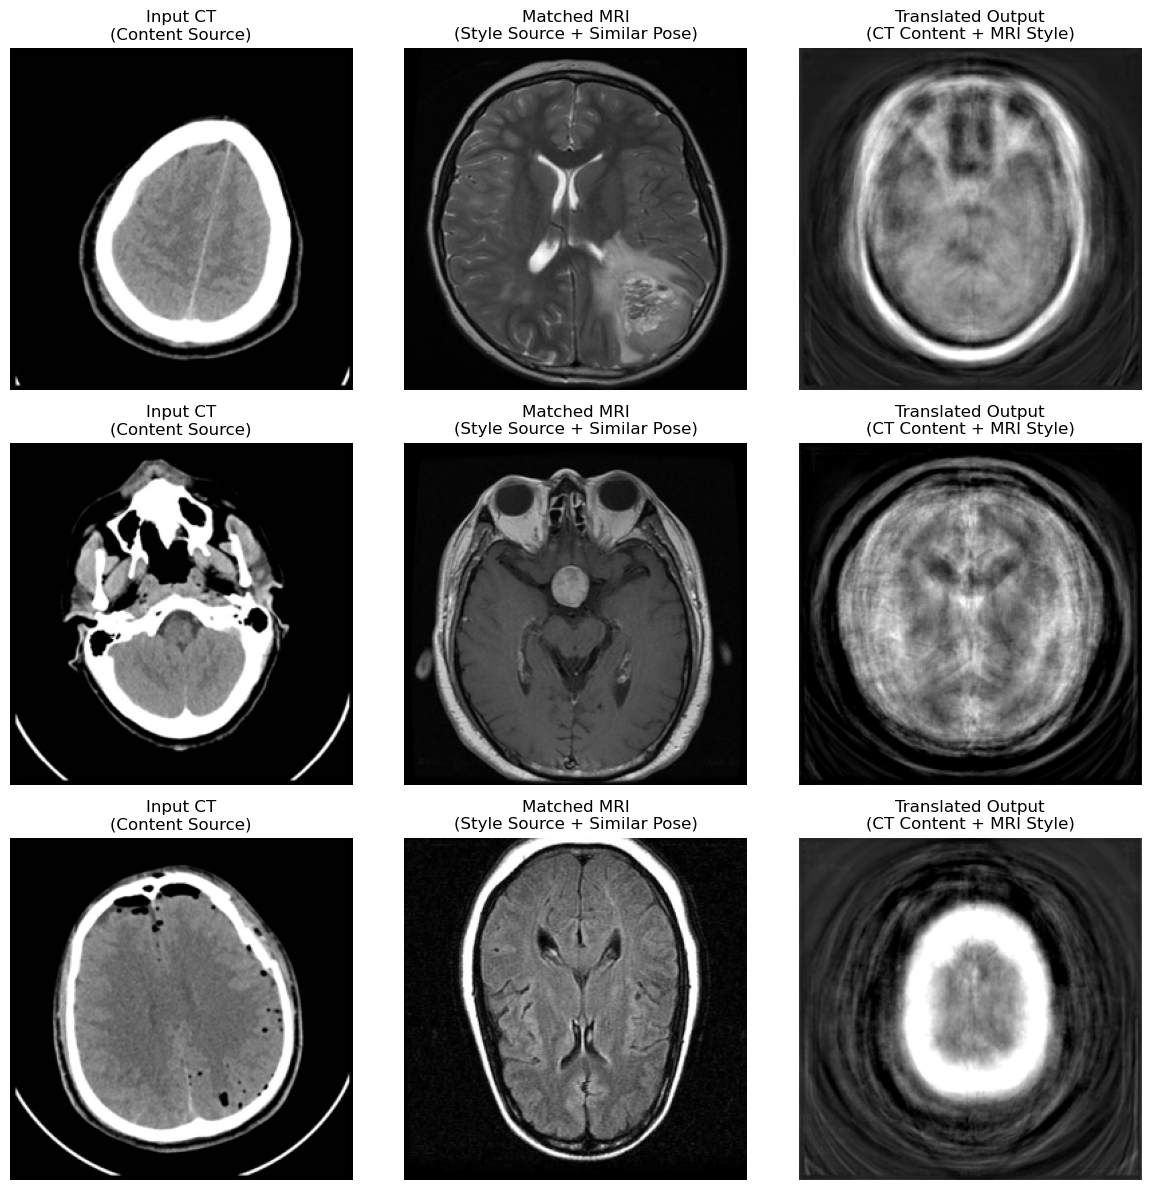

In [ ]:
from sklearn.neighbors import NearestNeighbors

# separate the latent vectors Z by domain
indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

def get_global_idx(subset_idx, domain):
    if domain == 'A': return indices_A[subset_idx]
    else: return indices_B[subset_idx]

# We match based ONLY on the Inactive (Content) dimensions.
# We want to find a MRI (B) that has the same pose as the query CT (A).

# Filter Z_B to keep only content dimensions
Z_B_content = Z_B[:, inactive_mask]

# Fit Nearest Neighbor model on Domain B's content
nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B_content)

def translate_A_to_B(idx_A_local, mu, std):
    # Get the A Latent
    z_CT = Z_A[idx_A_local]
    
    # Extract B Content
    content_query = z_CT[inactive_mask].reshape(1, -1)
    
    # Find the closest MRI (Match on Content)
    distances, indices = nbrs_B.kneighbors(content_query)
    idx_B_match = indices[0][0]
    z_MRI_match = Z_B[idx_B_match]
    
    # Synthesis
    # Start with zeros
    z_hybrid = np.zeros_like(z_CT)
    
    # Add CT Content (Pose)
    z_hybrid[inactive_mask] = z_CT[inactive_mask]
    
    # Add MRI Style (Texture)
    z_hybrid[active_mask] = z_MRI_match[active_mask]
    
    # Invert SVD
    w_hybrid = svd.inverse_transform(z_hybrid.reshape(1, -1))
    
    # Invert Wavelet 
    # img_translated = reconstruct_image_from_vector(
    #     sparse.csr_matrix(w_hybrid), coeff_slices, IMG_SIZE, coeff_shape
    # )
    img_translated = reconstruct_image_with_denorm(
        sparse.csr_matrix(w_hybrid), coeff_slices, IMG_SIZE, coeff_shape,
            mu, std, wavelet=WAVELET_TYPE)
    return img_translated, idx_B_match

# Picking random CTs to translate
test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    # Run Translation
    target_stats = df_meta.iloc[idx_A]
    mu = target_stats['mu']
    std = target_stats['std']
    img_fake_MRI, idx_B = translate_A_to_B(idx_A, mu, std)
    
    # Get Originals for Comparison
    global_idx_A = get_global_idx(idx_A, 'A')
    global_idx_B = get_global_idx(idx_B, 'B')
    
    img_real_CT = Image.open(df_meta.iloc[global_idx_A]['path']).convert('RGB').resize(IMG_SIZE)
    img_real_MRI_match = Image.open(df_meta.iloc[global_idx_B]['path']).convert('RGB').resize(IMG_SIZE)
    
    # Plotting
    # Column 1: Input CT
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_real_CT, cmap = 'gray')
    plt.title(f"Input CT\n(Content Source)")
    plt.axis('off')
    
    # Column 2: Matched MRI
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_real_MRI_match, cmap = 'gray')
    plt.title(f"Matched MRI\n(Style Source + Similar Pose)")
    plt.axis('off')
    
    # Column 3: Result
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake_MRI, cmap = 'gray')
    plt.title(f"Translated Output\n(CT Content + MRI Style)")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Diffusion Models

Processing 3486 images on cuda...


100%|██████████| 3486/3486 [00:06<00:00, 503.42it/s]


Matrix W constructed. Shape: torch.Size([3486, 65536])
Computing SVD... (This may take a moment)
SVD Complete.
U: torch.Size([3486, 3486]), S: torch.Size([3486]), Vt: torch.Size([3486, 65536])
✅ Saved SVD components and metadata to /home/shreyamm/Desktop/UPenn/projects/udt/experiments/ct2mri


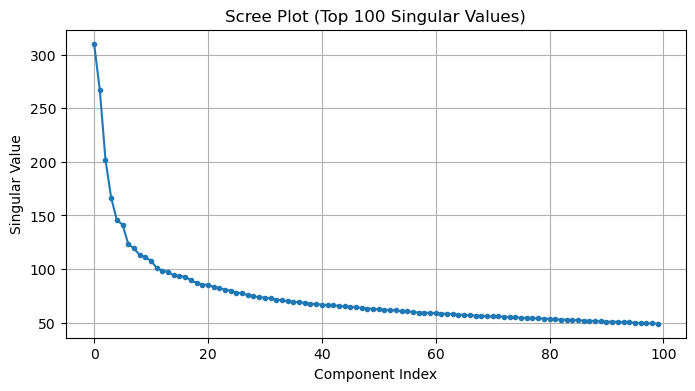

Reconstruction Error (Full Rank): 0.000000


/tmp/ipykernel_2125205/3532753344.py:194: UserWarning: Using a target size (torch.Size([65536])) that is different to the input size (torch.Size([1, 65536])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(f"Reconstruction Error (Full Rank): {F.mse_loss(recon_vec_full, W_tensor[0].to(DEVICE)).item():.6f}")


In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

WAVELET_TYPE = 'haar' # Using db1) for stability in differentiable pipeline
LEVEL = 3             # 3 levels of decomposition fits well with 256x256
IMG_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HOME_DIR = '/home/shreyamm/Desktop/UPenn/projects/udt/'
DATA_DIR = os.path.join(HOME_DIR, 'data/ct2mri/images')
EXP_DIR = os.path.join(HOME_DIR, 'experiments/ct2mri')

os.makedirs(EXP_DIR, exist_ok=True)

class DifferentiableDWT(nn.Module):
    """
    Multi-level Discrete Wavelet Transform using PyTorch Convolutions.
    Currently implements Haar (db1) which is 100% stable for differentiation.
    """
    def __init__(self, wavelet='haar', level=3):
        super().__init__()
        self.level = level
        self.wavelet = wavelet        
        self.dec_lo = torch.tensor([0.5, 0.5], device=DEVICE).view(1, 1, 1, 2)
        self.dec_hi = torch.tensor([-0.5, 0.5], device=DEVICE).view(1, 1, 1, 2)
        
    def forward_one_level(self, x):
        """
        x: (B, 1, H, W)
        Returns: LL, (LH, HL, HH)
        """
        x_pad = F.pad(x, (0, 0, 0, 0), mode='replicate') 

        rows_L = F.conv2d(x, self.dec_lo, stride=(1, 2))
        rows_H = F.conv2d(x, self.dec_hi, stride=(1, 2))
        
        # Column processing (transpose, conv, transpose back)
        # LL: Low on Rows, Low on Cols
        LL = F.conv2d(rows_L.transpose(2, 3), self.dec_lo, stride=(1, 2)).transpose(2, 3)
        # LH: Low on Rows, High on Cols
        LH = F.conv2d(rows_L.transpose(2, 3), self.dec_hi, stride=(1, 2)).transpose(2, 3)
        # HL: High on Rows, Low on Cols
        HL = F.conv2d(rows_H.transpose(2, 3), self.dec_lo, stride=(1, 2)).transpose(2, 3)
        # HH: High on Rows, High on Cols
        HH = F.conv2d(rows_H.transpose(2, 3), self.dec_hi, stride=(1, 2)).transpose(2, 3)
        
        return LL, (LH, HL, HH)

    def forward(self, x):
        """
        Full multi-level decomposition.
        Returns flattened vector of all coefficients for SVD usage.
        """
        coeffs_list = []
        current_x = x
        
        for i in range(self.level):
            LL, (LH, HL, HH) = self.forward_one_level(current_x)
            
            coeffs_list.append(LH.reshape(x.shape[0], -1))
            coeffs_list.append(HL.reshape(x.shape[0], -1))
            coeffs_list.append(HH.reshape(x.shape[0], -1))
            
            current_x = LL 
            
        coeffs_list.append(current_x.reshape(x.shape[0], -1))
        
        return torch.cat(coeffs_list, dim=1)

dwt_module = DifferentiableDWT(level=LEVEL).to(DEVICE)

def load_and_process_image(path):
    img = Image.open(path).convert("L").resize(IMG_SIZE)
    img_arr = np.array(img).astype(np.float32)
    
    img_arr = (img_arr / 127.5) - 1.0

    tensor = torch.from_numpy(img_arr).unsqueeze(0).unsqueeze(0).to(DEVICE)
    return tensor

files_A = glob.glob(f'{DATA_DIR}/trainA/*.png') # CT
files_B = glob.glob(f'{DATA_DIR}/trainB/*.jpg') # MRI

dataset_list = []
for f in files_A: dataset_list.append({'path': f, 'domain': 'CT', 'label': 0})
for f in files_B: dataset_list.append({'path': f, 'domain': 'MRI', 'label': 1})

random.shuffle(dataset_list)
print(f"Processing {len(dataset_list)} images on {DEVICE}...")

all_vectors = []
meta_rows = []

with torch.no_grad():
    for item in tqdm(dataset_list):
        img_tensor = load_and_process_image(item['path'])
        wavelet_vector = dwt_module(img_tensor)
        all_vectors.append(wavelet_vector.cpu())
        meta_rows.append(item)

W_tensor = torch.cat(all_vectors, dim=0) 
# print(f"Matrix W constructed. Shape: {W_tensor.shape}")
# print("Computing SVD... (This may take a moment)")
mean_vec = W_tensor.mean(dim=0, keepdim=True)
W_centered = W_tensor - mean_vec

if torch.cuda.is_available():
    W_centered = W_centered.to(DEVICE)

U, S, Vt = torch.linalg.svd(W_centered, full_matrices=False)

print(f"SVD Complete.")
print(f"U: {U.shape}, S: {S.shape}, Vt: {Vt.shape}")


torch.save({
    'U': U.cpu(),
    'S': S.cpu(),
    'Vt': Vt.cpu(),           # The Basis Vectors (Principal Components)
    'mean': mean_vec.cpu(),   # The Mean Vector (needed for projection)
    'W_shape': W_tensor.shape
}, os.path.join(EXP_DIR, 'svd_components.pt'))

pd.DataFrame(meta_rows).to_csv(os.path.join(EXP_DIR, 'metadata.csv'), index=False)



plt.figure(figsize=(8, 4))
plt.plot(S.cpu().numpy()[:100], marker='.')
plt.title("Scree Plot (Top 100 Singular Values)")
plt.xlabel("Component Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.savefig(os.path.join(EXP_DIR, 'scree_plot.png'))
plt.show()

recon_vec = (U[0, :k] * S[:k]) @ Vt[:k, :] + mean_vec.to(DEVICE) # Approximate
recon_vec_full = (U[0, :] * S[:]) @ Vt[:, :] + mean_vec.to(DEVICE) # Full

print(f"Reconstruction Error (Full Rank): {F.mse_loss(recon_vec_full, W_tensor[0].to(DEVICE)).item():.6f}")

Loading SVD components...


/tmp/ipykernel_2125205/1227389917.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(SVD_PATH)


Latent shape: torch.Size([3486, 3486])
Training Logistic Regression to find Active Components...


/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/shreyamm/miniconda3/envs/udt3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Total Components: 3486
Active (Discriminative) Components: 825
Inactive (Invariant) Components: 2661


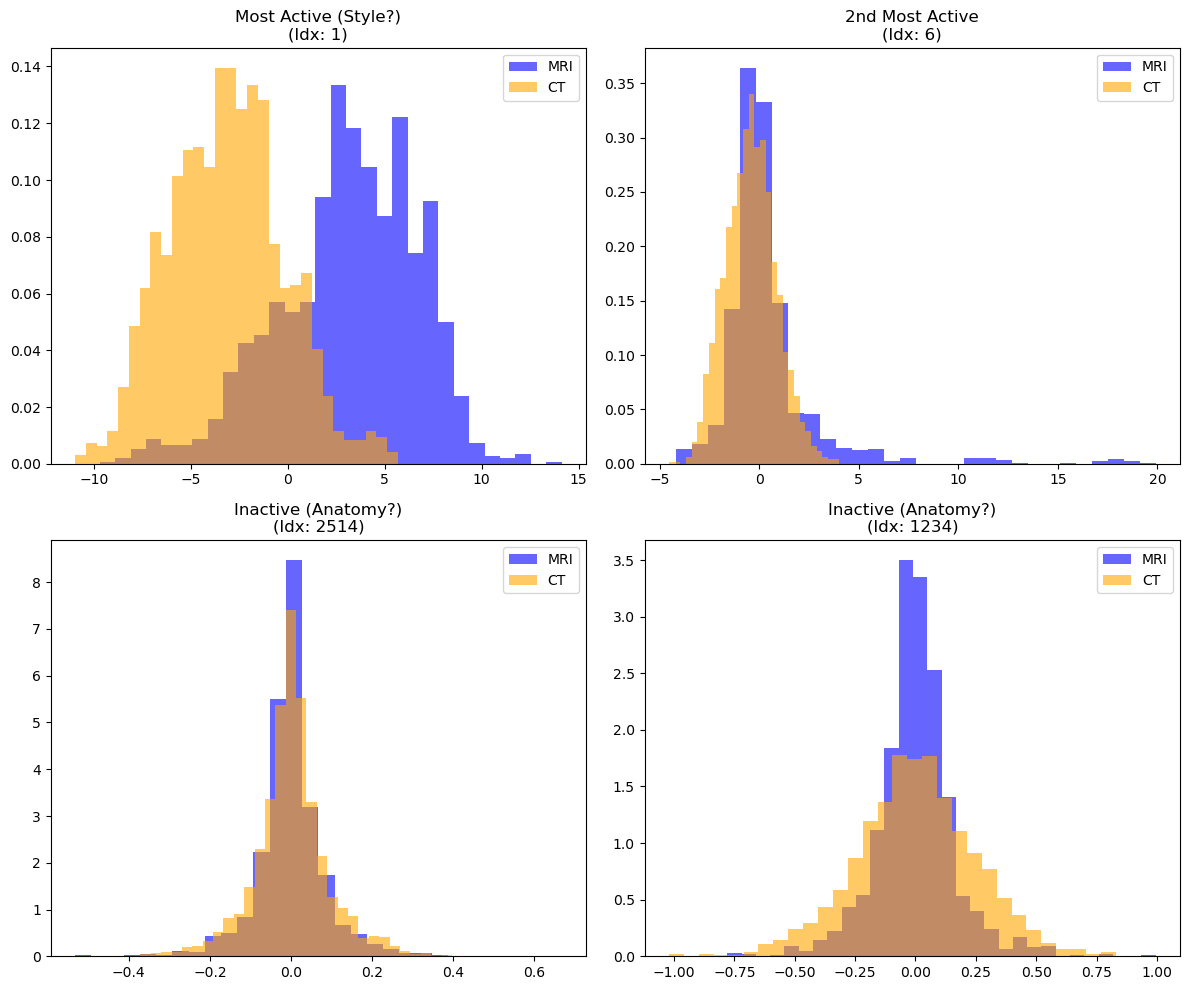

In [13]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# --- CONFIG ---
EXP_DIR = '/home/shreyamm/Desktop/UPenn/projects/udt/experiments/ct2mri'
SVD_PATH = f'{EXP_DIR}/svd_components.pt'
META_PATH = f'{EXP_DIR}/metadata.csv'

# --- 1. LOAD DATA ---
print("Loading SVD components...")
data = torch.load(SVD_PATH)
U = data['U'] # (N_images, N_images)
S = data['S'] # (N_images,)
# We don't need Vt or W for this step, just the projections

df_meta = pd.read_csv(META_PATH)
labels = (df_meta['domain'] == 'MRI').astype(int).values # 1=MRI, 0=CT

# --- 2. COMPUTE LATENT CODES (Z) ---
# Project data into the SVD space
# Z = U * S
# (N_images, N_components)
Z = U * S.unsqueeze(0) 

print(f"Latent shape: {Z.shape}")

# --- 3. TRAIN CLASSIFIER (Active vs Inactive) ---
# We use L1 penalty (Lasso) to encourage sparsity, making it very clear
# which components are actually useful for separation.
print("Training Logistic Regression to find Active Components...")

# Scale Z first (standard practice for Logistic Regression)
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(Z.numpy())

clf = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
clf.fit(Z_scaled, labels)

# Extract weights
weights = np.abs(clf.coef_[0])

# --- 4. IDENTIFY COMPONENTS ---
# Sort components by "Importance" (Weight)
# .copy() is ADDED here to fix the negative stride error
sorted_indices = np.argsort(weights)[::-1].copy() 

# Let's define "Inactive" as the bottom 50% of components, 
# or components with weights near zero.
n_components = len(weights)
n_active = np.sum(weights > 1e-3) # Threshold for "non-zero"

print(f"Total Components: {n_components}")
print(f"Active (Discriminative) Components: {n_active}")
print(f"Inactive (Invariant) Components: {n_components - n_active}")

# Save the indices
active_indices = sorted_indices[:n_active]
inactive_indices = sorted_indices[n_active:]

torch.save({
    'active_indices': torch.tensor(active_indices),
    'inactive_indices': torch.tensor(inactive_indices),
    'classifier_weights': torch.tensor(weights)
}, f'{EXP_DIR}/component_indices.pt')

# --- 5. VISUALIZATION (The "Overlap" Check) ---
def plot_separation(component_idx, ax, title):
    """Helper to plot histogram of MRI vs CT on a specific component"""
    z_vals = Z[:, component_idx].numpy()
    
    mri_vals = z_vals[labels == 1]
    ct_vals = z_vals[labels == 0]
    
    ax.hist(mri_vals, bins=30, alpha=0.6, label='MRI', color='blue', density=True)
    ax.hist(ct_vals, bins=30, alpha=0.6, label='CT', color='orange', density=True)
    ax.set_title(f"{title}\n(Idx: {component_idx})")
    ax.legend()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Top 2 ACTIVE (Should be separate)
plot_separation(active_indices[0], axes[0, 0], "Most Active (Style?)")
plot_separation(active_indices[1], axes[0, 1], "2nd Most Active")

# Plot Top 2 INACTIVE (Should overlap)
# We pick from the middle of the inactive pack to be safe, or just the first identified ones
safe_inactive = inactive_indices[0] 
plot_separation(safe_inactive, axes[1, 0], "Inactive (Anatomy?)")
plot_separation(inactive_indices[10], axes[1, 1], "Inactive (Anatomy?)")

plt.tight_layout()
plt.savefig(f'{EXP_DIR}/active_inactive_separation.png')
plt.show()

/tmp/ipykernel_2125205/1214624063.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'{EXP_DIR}/svd_components.pt')
/tmp/ipykernel_2125205/1214624063.py:

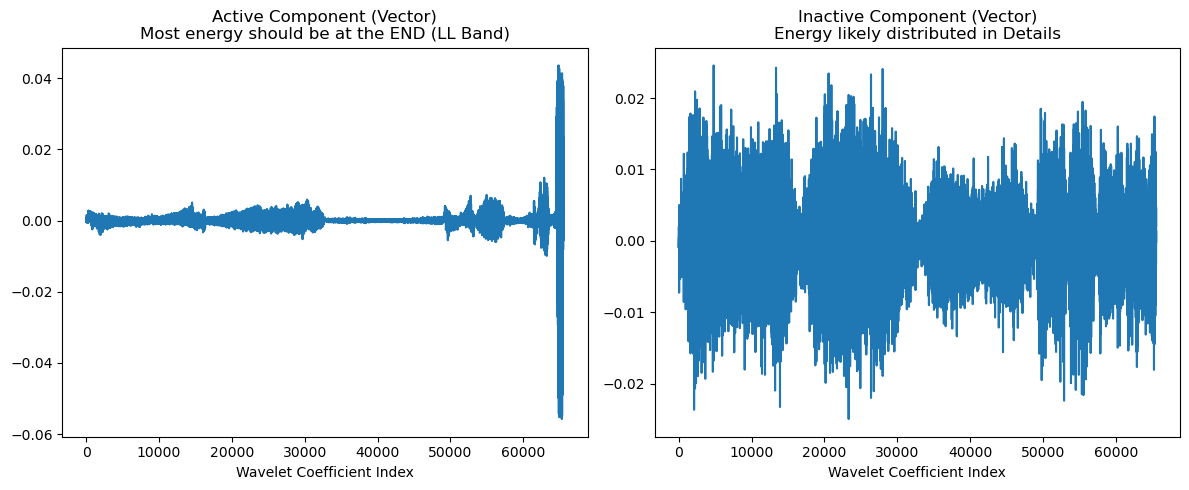

Energy in Low-Freq (Approx) Band:
Active Component:   96.03% (High = It's Brightness/Contrast)
Inactive Component: 8.57% (Low = It's Texture/Edges)


In [14]:
# --- VISUALIZE BASIS VECTORS ---
# We need to reverse the flattening to see the "Eigen-Wavelets"
# Since we don't have an Inverse DWT ready, we'll use a hack:
# We know the Last chunk of the vector is the "Approximation" (LL)

# Load components
data = torch.load(f'{EXP_DIR}/svd_components.pt')
Vt = data['Vt'] # (N_components, N_features)
indices = torch.load(f'{EXP_DIR}/component_indices.pt')

# Get the vectors
active_vec = Vt[indices['active_indices'][0]].numpy()   # Top Active
inactive_vec = Vt[indices['inactive_indices'][0]].numpy() # Top Inactive

# Plot the vector values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(active_vec)
plt.title(f"Active Component (Vector)\nMost energy should be at the END (LL Band)")
plt.xlabel("Wavelet Coefficient Index")

plt.subplot(1, 2, 2)
plt.plot(inactive_vec)
plt.title(f"Inactive Component (Vector)\nEnergy likely distributed in Details")
plt.xlabel("Wavelet Coefficient Index")

plt.tight_layout()
plt.show()

# Quick text check
n_coeffs = len(active_vec)
# In our DWT class, the Approximation (LL) is appended LAST.
# Let's see what % of the vector's energy is in the last 10% of coefficients (Approximation)
split_idx = int(n_coeffs * 0.90) 

active_energy_in_approx = np.sum(active_vec[split_idx:]**2) / np.sum(active_vec**2)
inactive_energy_in_approx = np.sum(inactive_vec[split_idx:]**2) / np.sum(inactive_vec**2)

print(f"Energy in Low-Freq (Approx) Band:")
print(f"Active Component:   {active_energy_in_approx*100:.2f}% (High = It's Brightness/Contrast)")
print(f"Inactive Component: {inactive_energy_in_approx*100:.2f}% (Low = It's Texture/Edges)")

/tmp/ipykernel_2125205/390933532.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'{EXP_DIR}/svd_components.pt')


Total Components: 3486
95% Energy Cutoff Index: 1479
Components discarded as noise: 2007

--- Final Selection ---
Active (Style) - Original: 825 -> Robust: 503
Inactive (Anatomy) - Original: 2661 -> Robust: 977


/tmp/ipykernel_2125205/390933532.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  indices = torch.load(f'{EXP_DIR}/component_indices.pt')


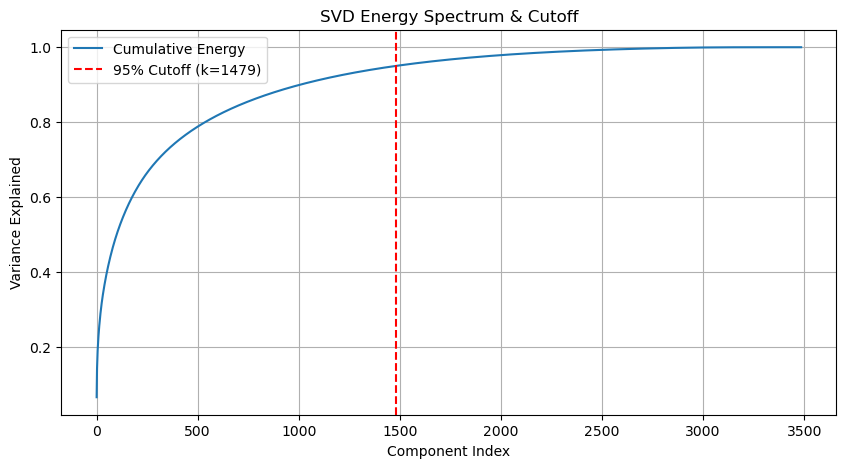

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- LOAD DATA ---
EXP_DIR = '/home/shreyamm/Desktop/UPenn/projects/udt/experiments/ct2mri'
data = torch.load(f'{EXP_DIR}/svd_components.pt')
indices = torch.load(f'{EXP_DIR}/component_indices.pt')

S = data['S'].numpy() # Singular Values
weights = indices['classifier_weights'].numpy()
active_original = indices['active_indices'].numpy()
inactive_original = indices['inactive_indices'].numpy()

# --- 1. DETERMINE ENERGY THRESHOLD ---
# Energy = Square of singular values
energy = S ** 2
total_energy = np.sum(energy)
cumulative_energy = np.cumsum(energy) / total_energy

# Find the index where we cross 95% variance explained
# You can tweak this: 0.90 is stricter (less noise), 0.99 is looser (more detail)
THRESHOLD_RATIO = 0.95 
k_cutoff = np.argmax(cumulative_energy >= THRESHOLD_RATIO)

print(f"Total Components: {len(S)}")
print(f"95% Energy Cutoff Index: {k_cutoff}")
print(f"Components discarded as noise: {len(S) - k_cutoff}")

# --- 2. FILTER THE LISTS ---
# We simply ignore any component index > k_cutoff
# This is mathematically equivalent to having computed a truncated SVD of size k_cutoff

# Filter Active (Style)
# (Active components are usually early in the spectrum, so this might not change much)
robust_active = [idx for idx in active_original if idx <= k_cutoff]

# Filter Inactive (Anatomy)
# (This is where the magic happens - dropping the noisy tail)
robust_inactive = [idx for idx in inactive_original if idx <= k_cutoff]

print(f"\n--- Final Selection ---")
print(f"Active (Style) - Original: {len(active_original)} -> Robust: {len(robust_active)}")
print(f"Inactive (Anatomy) - Original: {len(inactive_original)} -> Robust: {len(robust_inactive)}")

# --- 3. SAVE FINAL SET ---
torch.save({
    'active_indices': torch.tensor(robust_active),
    'inactive_indices': torch.tensor(robust_inactive),
    'classifier_weights': indices['classifier_weights'],
    'cutoff_index': k_cutoff
}, f'{EXP_DIR}/component_indices_robust.pt')

# --- 4. VISUALIZATION ---
plt.figure(figsize=(10, 5))
plt.plot(cumulative_energy, label='Cumulative Energy')
plt.axvline(x=k_cutoff, color='r', linestyle='--', label=f'95% Cutoff (k={k_cutoff})')
plt.title("SVD Energy Spectrum & Cutoff")
plt.xlabel("Component Index")
plt.ylabel("Variance Explained")
plt.legend()
plt.grid(True)
plt.show()